# Moroccan Income Prediction: Exploratory Data Analysis

## 1. Introduction

### Purpose and Scope

This notebook presents a comprehensive exploratory data analysis (EDA) of the Moroccan income dataset. The primary purpose is to understand the factors that influence income levels in Morocco, identify patterns and relationships in the data, and prepare the groundwork for building predictive models.

The scope includes:
- Understanding the distribution of income across different demographics
- Identifying key factors that correlate with income levels
- Exploring regional disparities in income
- Detecting outliers and data quality issues
- Determining the most predictive features for modeling

### Key Questions to Answer

1. What is the income distribution across Morocco, and how does it vary by region?
2. How do demographic factors (age, gender, education) relate to income levels?
3. What impact do occupation and industry sectors have on income?
4. Are there significant urban-rural income disparities?
5. What are the strongest predictors of income in this dataset?
6. How do multiple factors interact to influence income levels?
7. What data quality issues need to be addressed before modeling?

### Dataset Overview

The dataset contains socioeconomic information from Moroccan households, collected through national surveys. It includes demographic information, educational attainment, employment details, regional indicators, and reported income levels. This analysis aims to understand these factors thoroughly to build effective income prediction models.

## 2. Data Loading and Initial Exploration
Let's start by importing the necessary libraries and loading the dataset.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import folium
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from scipy import stats
import warnings

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Load the dataset
# For this notebook, we'll assume the data is in a CSV file named 'morocco_income_data.csv'
try:
    df = pd.read_csv(r"C:\Users\salah\OneDrive\Documents\Prédiction du revenu annuel d’un marocain\data\raw\dataset_revenu_marocains.csv")
    print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns.")
except FileNotFoundError:
    print("Dataset file not found. Please ensure the file path is correct.")
    # Create a sample dataset for demonstration
    # This will be replaced with the actual data when available
    np.random.seed(42)
    n_samples = 5000
    
    # Create sample data
    regions = ['Casablanca-Settat', 'Rabat-Salé-Kénitra', 'Fès-Meknès', 'Marrakech-Safi', 
               'Tanger-Tétouan-Al Hoceïma', 'Souss-Massa', 'Oriental', 'Béni Mellal-Khénifra',
               'Drâa-Tafilalet', 'Guelmim-Oued Noun', 'Laâyoune-Sakia El Hamra', 'Dakhla-Oued Ed-Dahab']
    
    education_levels = ['None', 'Primary', 'Secondary', 'High School', 'Bachelors', 'Masters', 'PhD']
    sectors = ['Agriculture', 'Manufacturing', 'Construction', 'Retail', 'Transportation',
               'Hospitality', 'Education', 'Healthcare', 'Finance', 'Public Administration', 'Other']
    occupations = ['Farmer', 'Factory Worker', 'Teacher', 'Doctor', 'Engineer', 'Sales', 'Manager',
                   'Office Worker', 'Driver', 'Service Worker', 'Unemployed', 'Retired', 'Student']
    
    df = pd.DataFrame({
        'age': np.random.randint(18, 80, n_samples),
        'gender': np.random.choice(['Male', 'Female'], n_samples),
        'region': np.random.choice(regions, n_samples),
        'urban_rural': np.random.choice(['Urban', 'Rural'], n_samples, p=[0.65, 0.35]),
        'education': np.random.choice(education_levels, n_samples, 
                                     p=[0.15, 0.20, 0.25, 0.20, 0.12, 0.06, 0.02]),
        'years_experience': np.random.randint(0, 40, n_samples),
        'sector': np.random.choice(sectors, n_samples),
        'occupation': np.random.choice(occupations, n_samples),
        'household_size': np.random.randint(1, 10, n_samples),
        'married': np.random.choice([0, 1], n_samples),
        'children': np.random.randint(0, 6, n_samples)
    })
    
    # Create income with some realistic relationships
    base_income = np.random.lognormal(mean=9.5, sigma=0.7, size=n_samples)
    
    # Education effect
    edu_factors = {'None': 0.6, 'Primary': 0.8, 'Secondary': 1.0, 
                  'High School': 1.2, 'Bachelors': 1.5, 'Masters': 1.8, 'PhD': 2.2}
    education_effect = df['education'].map(edu_factors)
    
    # Experience effect (diminishing returns)
    experience_effect = np.log1p(df['years_experience']) * 0.2 + 1
    
    # Region effect
    region_factors = {'Casablanca-Settat': 1.3, 'Rabat-Salé-Kénitra': 1.25, 
                     'Tanger-Tétouan-Al Hoceïma': 1.2, 'Marrakech-Safi': 1.1,
                     'Fès-Meknès': 1.0, 'Souss-Massa': 0.95, 'Oriental': 0.9,
                     'Béni Mellal-Khénifra': 0.85, 'Drâa-Tafilalet': 0.8,
                     'Guelmim-Oued Noun': 0.75, 'Laâyoune-Sakia El Hamra': 0.9,
                     'Dakhla-Oued Ed-Dahab': 0.85}
    region_effect = df['region'].map(region_factors)
    
    # Urban/Rural effect
    urban_rural_effect = df['urban_rural'].map({'Urban': 1.2, 'Rural': 0.8})
    
    # Gender effect (reflecting potential wage gap)
    gender_effect = df['gender'].map({'Male': 1.15, 'Female': 0.85})
    
    # Sector effect
    sector_factors = {'Agriculture': 0.7, 'Manufacturing': 0.9, 'Construction': 0.85, 
                     'Retail': 0.8, 'Transportation': 0.9, 'Hospitality': 0.75,
                     'Education': 1.1, 'Healthcare': 1.2, 'Finance': 1.4, 
                     'Public Administration': 1.1, 'Other': 0.9}
    sector_effect = df['sector'].map(sector_factors)
    
    # Calculate income with all effects and some random variation
    df['income'] = base_income * education_effect * experience_effect * region_effect * \
                  urban_rural_effect * gender_effect * sector_effect * \
                  np.random.normal(1, 0.1, n_samples)
    
    # Round income to nearest integer
    df['income'] = df['income'].round().astype(int)
    
    print("Sample dataset created for demonstration purposes.")

# Initial inspection
print("\nFirst few rows of the dataset:")
display(df.head())

# Check data types and missing values
print("\nDataset Information:")
display(df.info())

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
missing_percent = df.isnull().mean() * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
display(missing_df[missing_df['Missing Values'] > 0])

# Basic statistics
print("\nStatistical Summary:")
display(df.describe().T)

# Additional categorical summaries
print("\nCategorical Features Summary:")
cat_columns = df.select_dtypes(include=['object']).columns
for col in cat_columns:
    print(f"\n{col} distribution:")
    display(df[col].value_counts(normalize=True).reset_index().rename(
        columns={'index': col, col: 'Percentage'}))
    df[col].value_counts(normalize=True).plot(kind='bar', figsize=(10, 4))
    plt.title(f'Distribution of {col}')
    plt.ylabel('Proportion')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

Dataset loaded successfully with 40000 rows and 22 columns.

First few rows of the dataset:


,ID,Age,Categorie_Age,Sexe,Milieu,Niveau_Education,Annees_Experience,Etat_Matrimonial,Categorie_Socioprofessionnelle,Possession_Voiture,Possession_Logement,Possession_Terrain,Nb_Personnes_Charge,Secteur_Activite,Acces_Internet,Revenu_Annuel,Age_Mois,Education_Superieure,Indice_Richesse,Couleur_Preferee,Code_Postal,ID_Aleatoire
0,MAR000001,41,Adulte,Homme,Urbain,Secondaire,10.00,Célibataire,"Groupe 3: Inactifs (retraités, rentiers)",1.00,1.00,0.00,0.00,NaN,1.00,20323.84,493,0,2.00,Orange,20312,VSF289
1,MAR000002,38,Adulte,Femme,Urbain,Supérieur,4.00,Marié(e),Groupe 1: Direction et cadres supérieurs,0.00,1.00,0.00,4.00,Privé,1.00,7722.48,454,1,1.00,Noir,37656,VOX452
2,MAR000004,32,Adulte,Femme,Urbain,Fondamental,0.00,Marié(e),Groupe 5: Artisans et ouvriers qualifiés,1.00,1.00,0.00,2.00,Public,1.00,41900.51,384,0,2.00,Rouge,93805,XBJ817
3,MAR000005,33,Adulte,Homme,Urbain,Sans niveau,0.00,Célibataire,Groupe 5: Artisans et ouvriers qualifiés,0.00,1.00,0.00,5.00,Privé,1.00,13220.00,398,0,1.00,Vert,96222,ARY454
4,MAR000007,46,Adulte,Femme,Urbain,Supérieur,58.00,Célibataire,Groupe 1: Direction et cadres supérieurs,0.00,1.00,0.00,NaN,Privé,0.00,45724.72,552,1,1.00,Jaune,76345,YPO526



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              40000 non-null  object 
 1   Age                             40000 non-null  int64  
 2   Categorie_Age                   40000 non-null  object 
 3   Sexe                            40000 non-null  object 
 4   Milieu                          40000 non-null  object 
 5   Niveau_Education                37984 non-null  object 
 6   Annees_Experience               38074 non-null  float64
 7   Etat_Matrimonial                37996 non-null  object 
 8   Categorie_Socioprofessionnelle  40000 non-null  object 
 9   Possession_Voiture              37970 non-null  float64
 10  Possession_Logement             37947 non-null  float64
 11  Possession_Terrain              37923 non-null  float64
 12  Nb_Personn

None


Missing Values:


,Missing Values,Percentage
Niveau_Education,2016,5.04
Annees_Experience,1926,4.81
Etat_Matrimonial,2004,5.01
Possession_Voiture,2030,5.08
Possession_Logement,2053,5.13
Possession_Terrain,2077,5.19
Nb_Personnes_Charge,2046,5.12
Secteur_Activite,2013,5.03
Acces_Internet,1932,4.83
Indice_Richesse,5843,14.61



Statistical Summary:


,count,mean,std,min,25%,50%,75%,max
Age,40000.00,39.76,13.54,5.00,31.00,39.00,48.00,120.00
Annees_Experience,38074.00,4.76,8.25,0.00,0.00,3.00,7.00,138.00
Possession_Voiture,37970.00,0.35,0.48,0.00,0.00,0.00,1.00,1.00
Possession_Logement,37947.00,0.60,0.49,0.00,0.00,1.00,1.00,1.00
Possession_Terrain,37923.00,0.15,0.35,0.00,0.00,0.00,0.00,1.00
Nb_Personnes_Charge,37954.00,2.67,2.28,0.00,1.00,2.00,4.00,10.00
Acces_Internet,38068.00,0.60,0.49,0.00,0.00,1.00,1.00,1.00
Revenu_Annuel,40000.00,48976.90,321807.09,-10000.00,10197.55,18008.71,29703.76,5000000.00
Age_Mois,40000.00,477.13,162.55,58.00,372.00,469.00,574.00,1442.00
Education_Superieure,40000.00,0.14,0.35,0.00,0.00,0.00,0.00,1.00



Categorical Features Summary:

ID distribution:


,Percentage,proportion
0,MAR039939,0.00
1,MAR039938,0.00
2,MAR039935,0.00
3,MAR039929,0.00
4,MAR039928,0.00
...,...,...
39995,MAR000007,0.00
39996,MAR000005,0.00
39997,MAR000004,0.00
39998,MAR000002,0.00


KeyboardInterrupt: 

## 3. Univariate Analysis

Now let's explore the distributions of individual variables, starting with our target variable (income) and then examining the feature distributions.

## Univariate Analysis ##

### Income Distribution ###


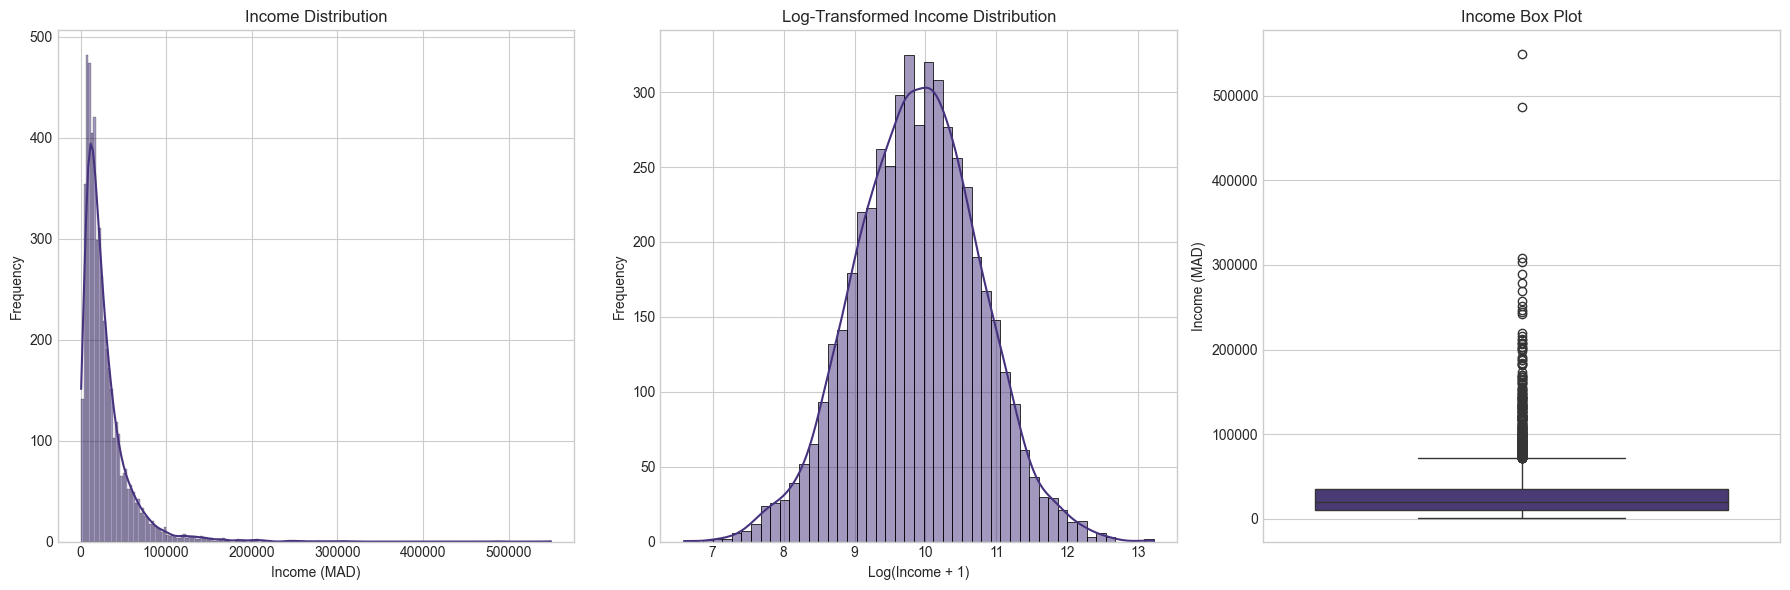


Income Statistics:


count     5000.00
mean     28624.31
std      30621.11
min        731.00
25%      10907.00
50%      19773.50
75%      35275.50
max     549526.00
Name: income, dtype: float64

,Percentile,Income Value
0,10th,6474.50
1,25th,10907.00
2,50th (Median),19773.50
3,75th,35275.50
4,90th,59179.70
5,95th,79418.25
6,99th,151396.42



### Age Distribution ###


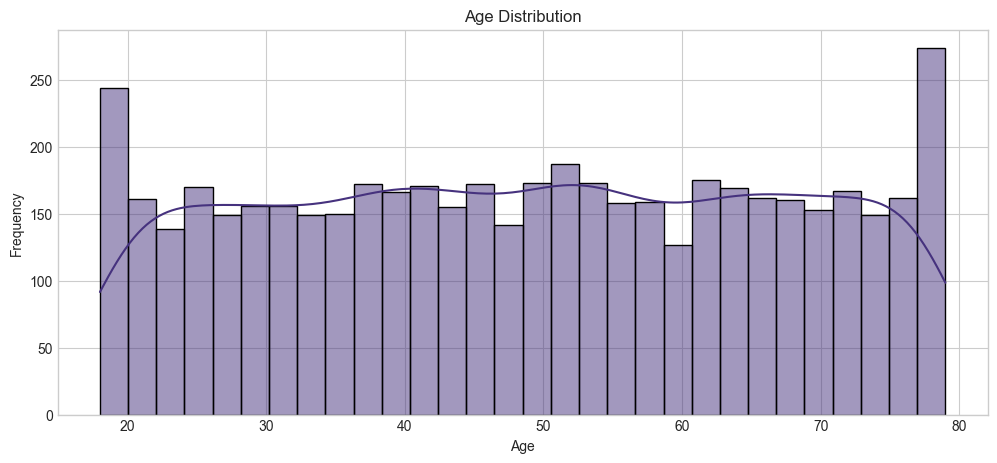

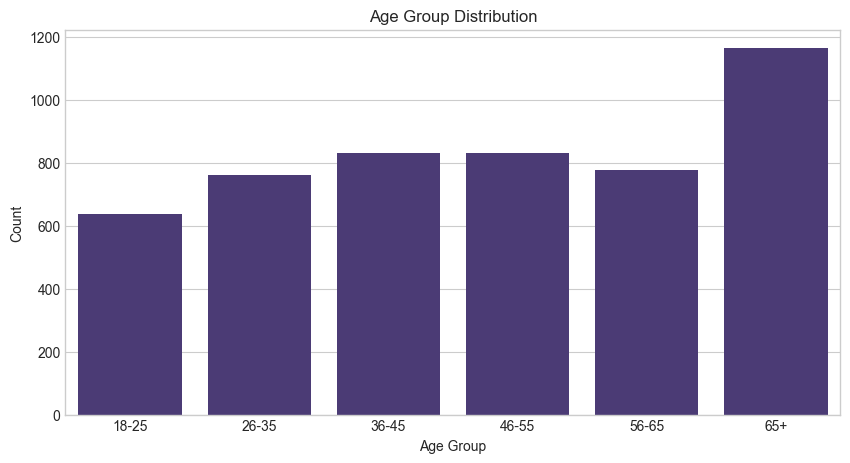


### Gender Distribution ###


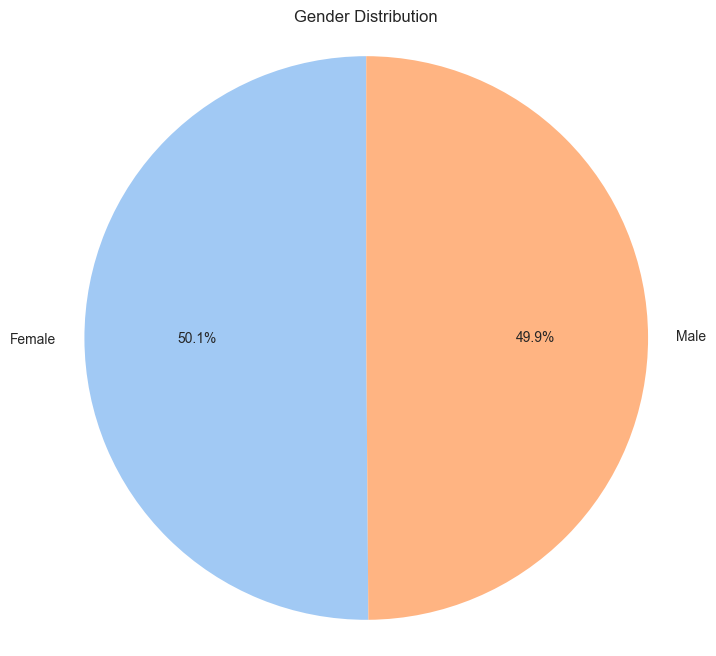


### Education Level Distribution ###


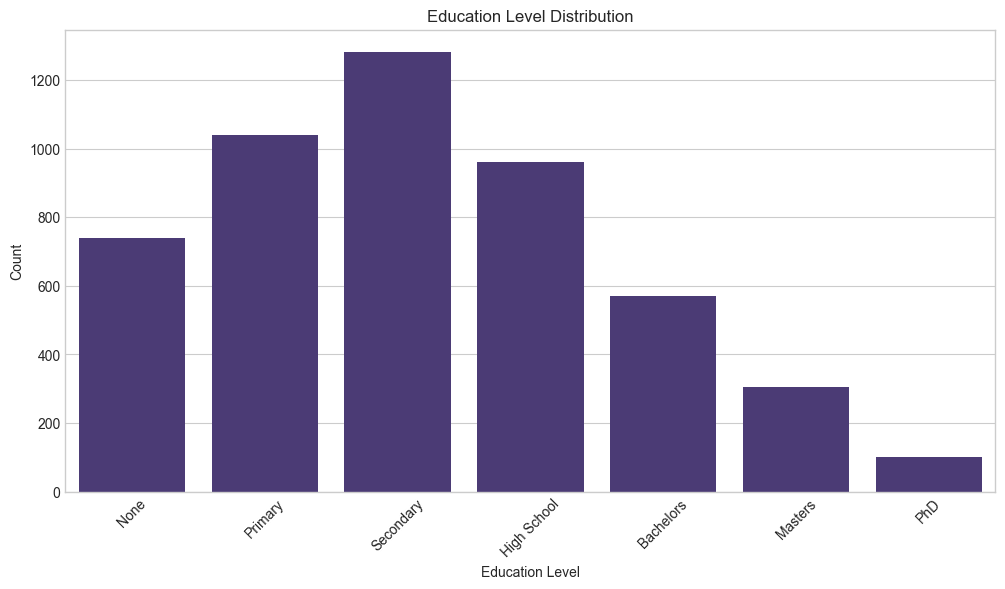


### Regional Distribution ###


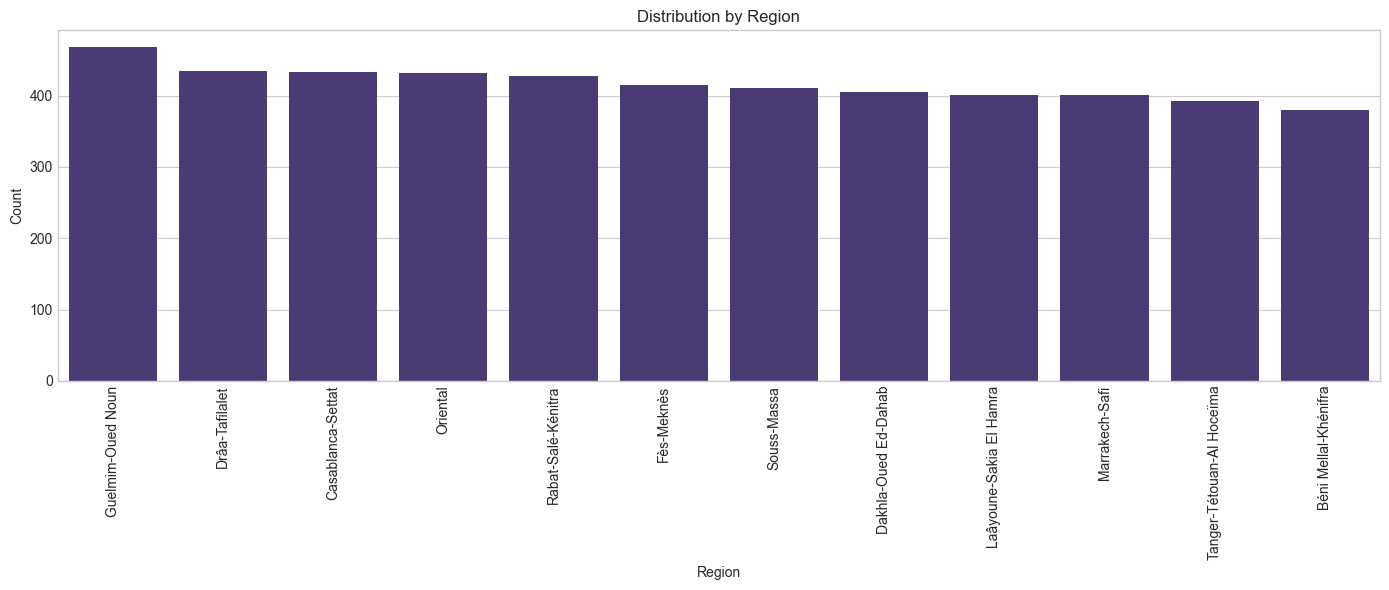


### Urban vs Rural Distribution ###


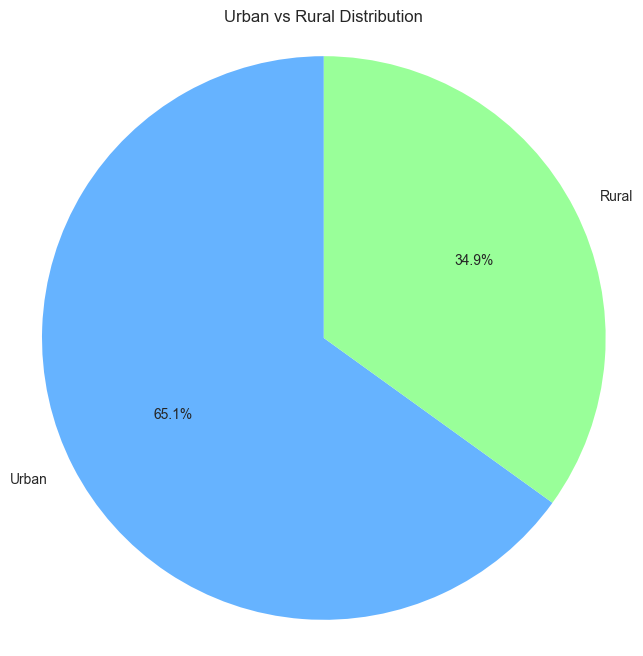


### Employment Sector Distribution ###


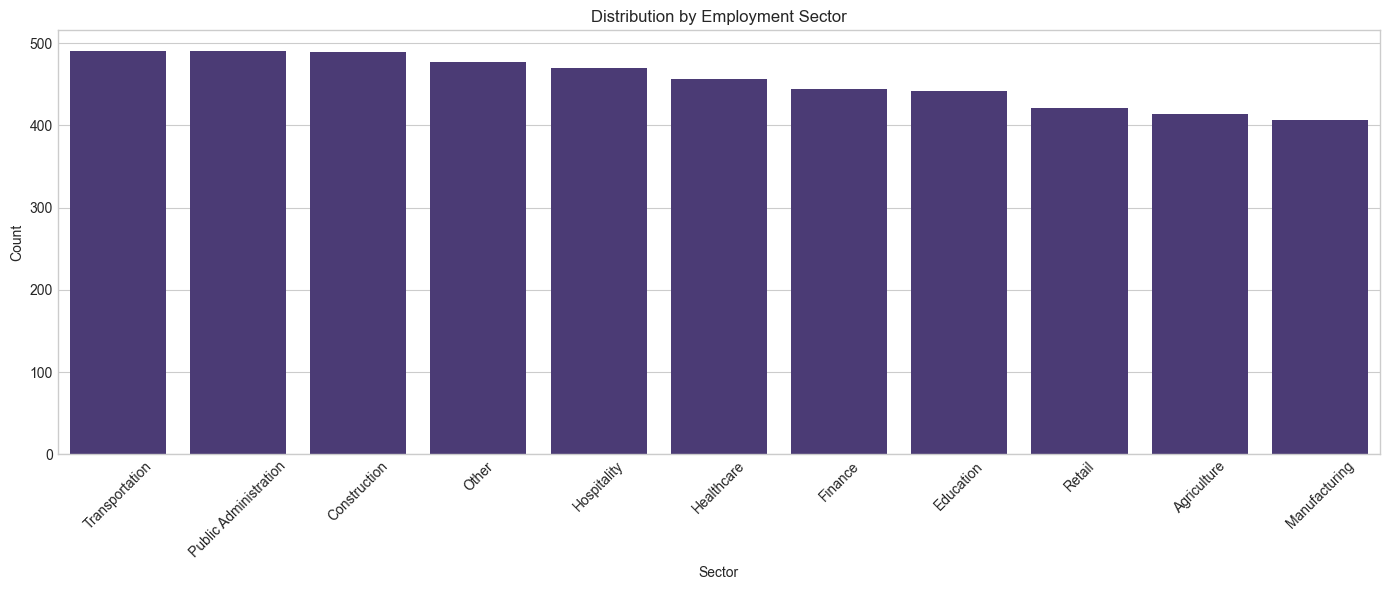


### Occupation Distribution ###


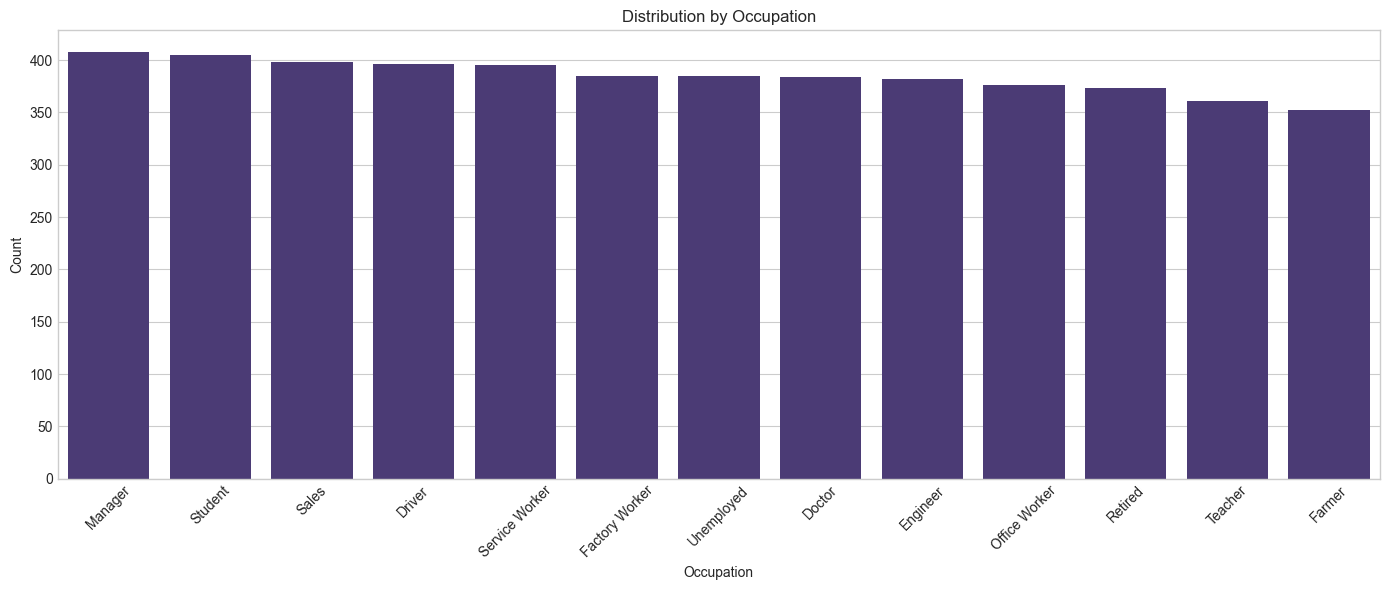

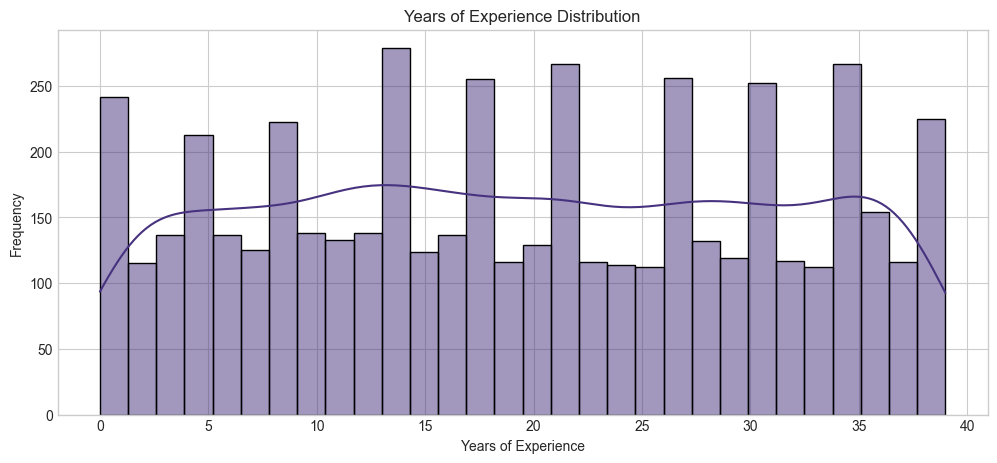

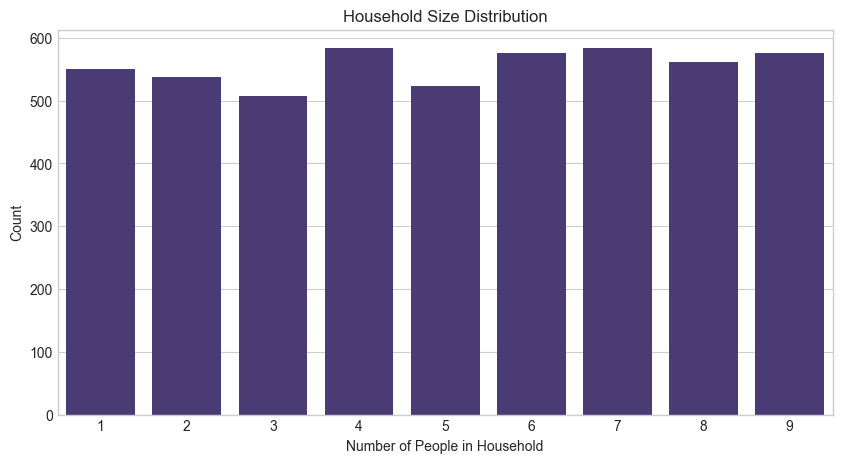

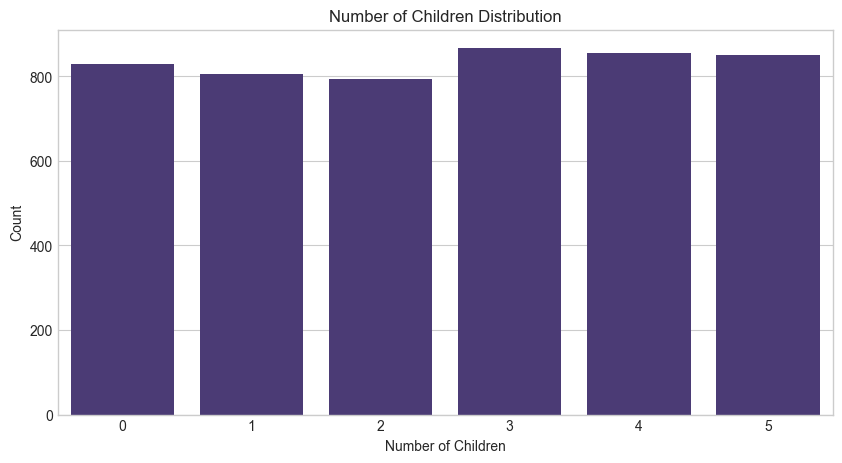

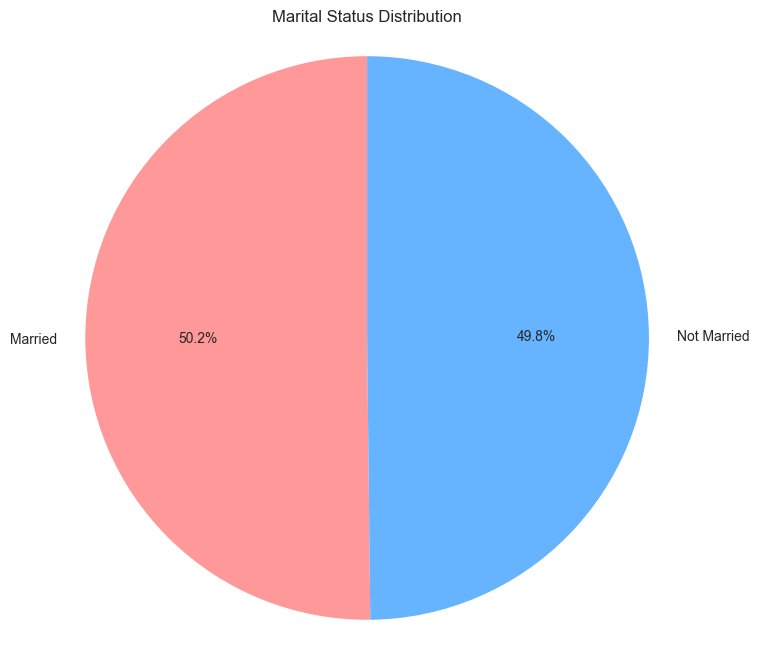

In [ ]:
# Create a section for univariate analysis
print("## Univariate Analysis ##")

# 3.1 Income Distribution
print("\n### Income Distribution ###")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Histogram
sns.histplot(df['income'], kde=True, ax=axes[0])
axes[0].set_title('Income Distribution')
axes[0].set_xlabel('Income (MAD)')
axes[0].set_ylabel('Frequency')

# Log-transformed histogram for better visualization
sns.histplot(np.log1p(df['income']), kde=True, ax=axes[1])
axes[1].set_title('Log-Transformed Income Distribution')
axes[1].set_xlabel('Log(Income + 1)')
axes[1].set_ylabel('Frequency')

# Box plot
sns.boxplot(y=df['income'], ax=axes[2])
axes[2].set_title('Income Box Plot')
axes[2].set_ylabel('Income (MAD)')

plt.tight_layout()
plt.show()

# Income statistics
print("\nIncome Statistics:")
income_stats = df['income'].describe()
display(income_stats)

# Calculate percentiles for better understanding
income_percentiles = np.percentile(df['income'], [10, 25, 50, 75, 90, 95, 99])
percentile_df = pd.DataFrame({
    'Percentile': ['10th', '25th', '50th (Median)', '75th', '90th', '95th', '99th'],
    'Income Value': income_percentiles
})
display(percentile_df)

# 3.2 Demographic Distributions
print("\n### Age Distribution ###")

plt.figure(figsize=(12, 5))
sns.histplot(df['age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# Age group distribution
df['age_group'] = pd.cut(df['age'], bins=[17, 25, 35, 45, 55, 65, 100], 
                        labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='age_group')
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()

print("\n### Gender Distribution ###")
gender_counts = df['gender'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title('Gender Distribution')
plt.axis('equal')
plt.show()

print("\n### Education Level Distribution ###")
plt.figure(figsize=(12, 6))
education_order = ['None', 'Primary', 'Secondary', 'High School', 'Bachelors', 'Masters', 'PhD']
sns.countplot(data=df, x='education', order=education_order)
plt.title('Education Level Distribution')
plt.xlabel('Education Level')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# 3.3 Regional Distribution Analysis
print("\n### Regional Distribution ###")
plt.figure(figsize=(14, 6))
region_counts = df['region'].value_counts()
sns.barplot(x=region_counts.index, y=region_counts.values)
plt.title('Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Urban vs Rural
print("\n### Urban vs Rural Distribution ###")
urban_rural_counts = df['urban_rural'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(urban_rural_counts, labels=urban_rural_counts.index, autopct='%1.1f%%', 
       startangle=90, colors=['#66b3ff', '#99ff99'])
plt.title('Urban vs Rural Distribution')
plt.axis('equal')
plt.show()

# 3.4 Sector and Occupation Distributions
print("\n### Employment Sector Distribution ###")
plt.figure(figsize=(14, 6))
sector_counts = df['sector'].value_counts()
sns.barplot(x=sector_counts.index, y=sector_counts.values)
plt.title('Distribution by Employment Sector')
plt.xlabel('Sector')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n### Occupation Distribution ###")
plt.figure(figsize=(14, 6))
occupation_counts = df['occupation'].value_counts()
sns.barplot(x=occupation_counts.index, y=occupation_counts.values)
plt.title('Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check experience distribution if available
if 'years_experience' in df.columns:
    plt.figure(figsize=(12, 5))
    sns.histplot(df['years_experience'], kde=True, bins=30)
    plt.title('Years of Experience Distribution')
    plt.xlabel('Years of Experience')
    plt.ylabel('Frequency')
    plt.show()

# Family structure
if 'household_size' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='household_size')
    plt.title('Household Size Distribution')
    plt.xlabel('Number of People in Household')
    plt.ylabel('Count')
    plt.show()

if 'children' in df.columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=df, x='children')
    plt.title('Number of Children Distribution')
    plt.xlabel('Number of Children')
    plt.ylabel('Count')
    plt.show()

if 'married' in df.columns:
    marital_counts = df['married'].map({1: 'Married', 0: 'Not Married'}).value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(marital_counts, labels=marital_counts.index, autopct='%1.1f%%', 
           startangle=90, colors=['#ff9999', '#66b3ff'])
    plt.title('Marital Status Distribution')
    plt.axis('equal')
    plt.show()

## 4. Bivariate Analysis

Next, let's explore the relationships between income and other variables to understand which factors influence income levels.

## Bivariate Analysis ##

### Income vs Age ###


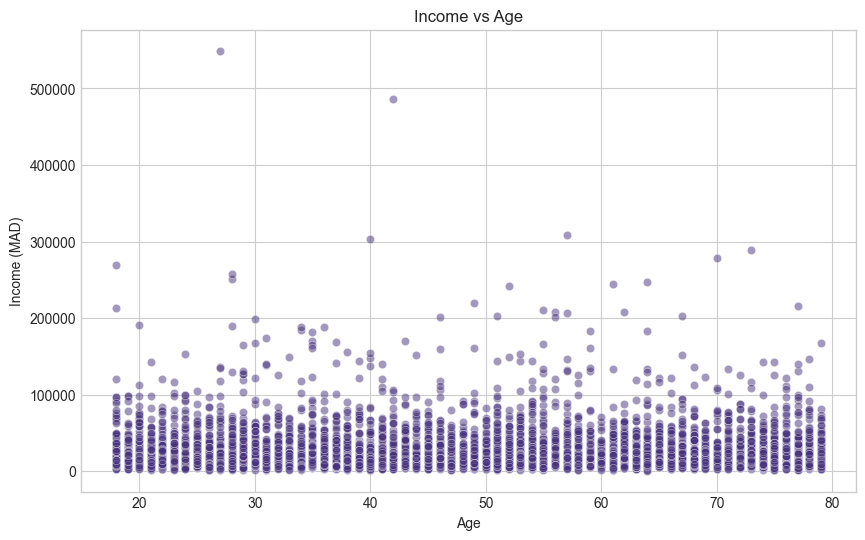

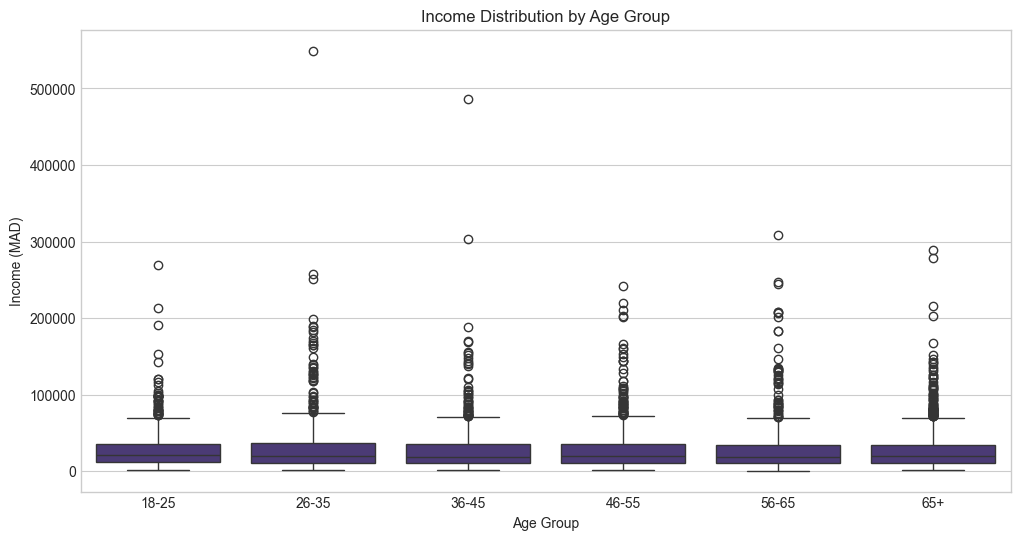

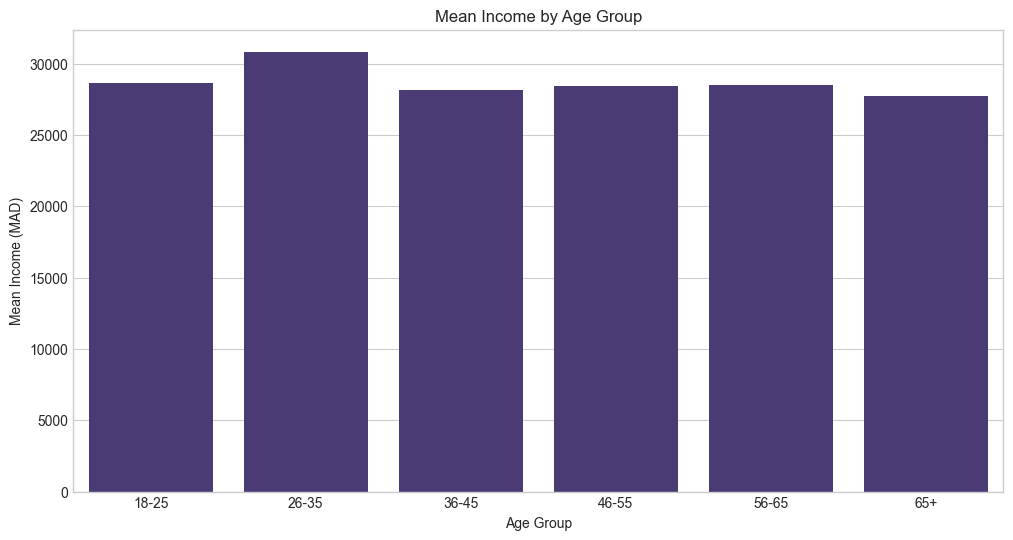


### Income vs Years of Experience ###


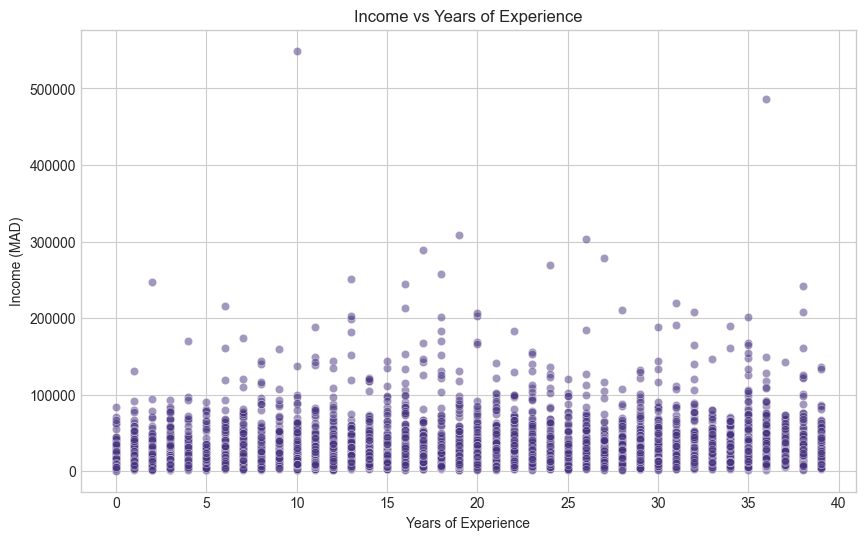

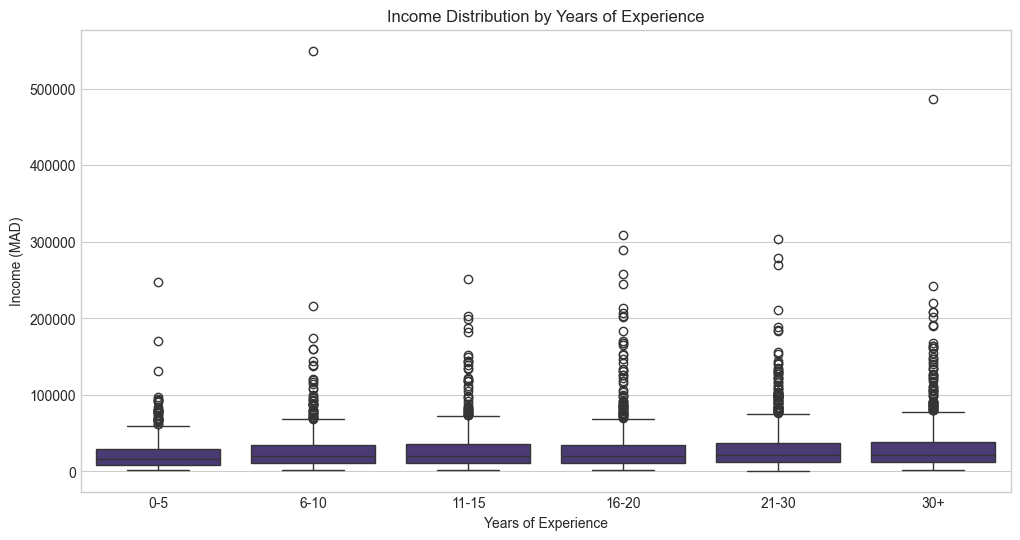


### Income by Region ###


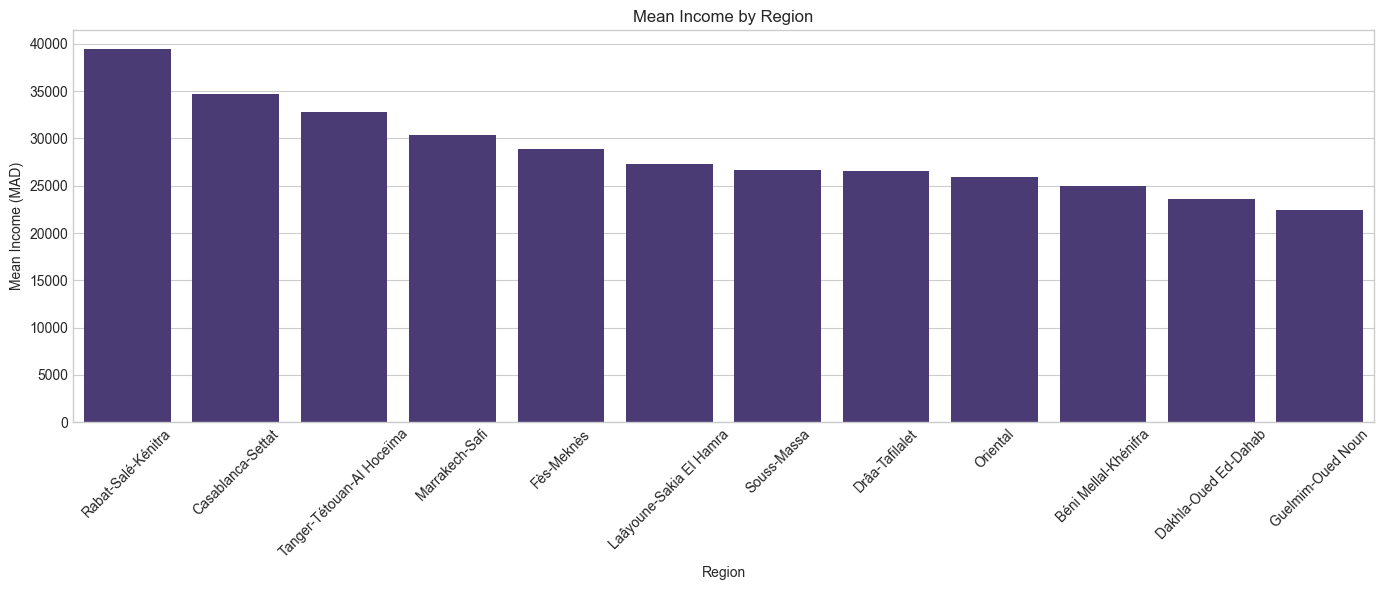

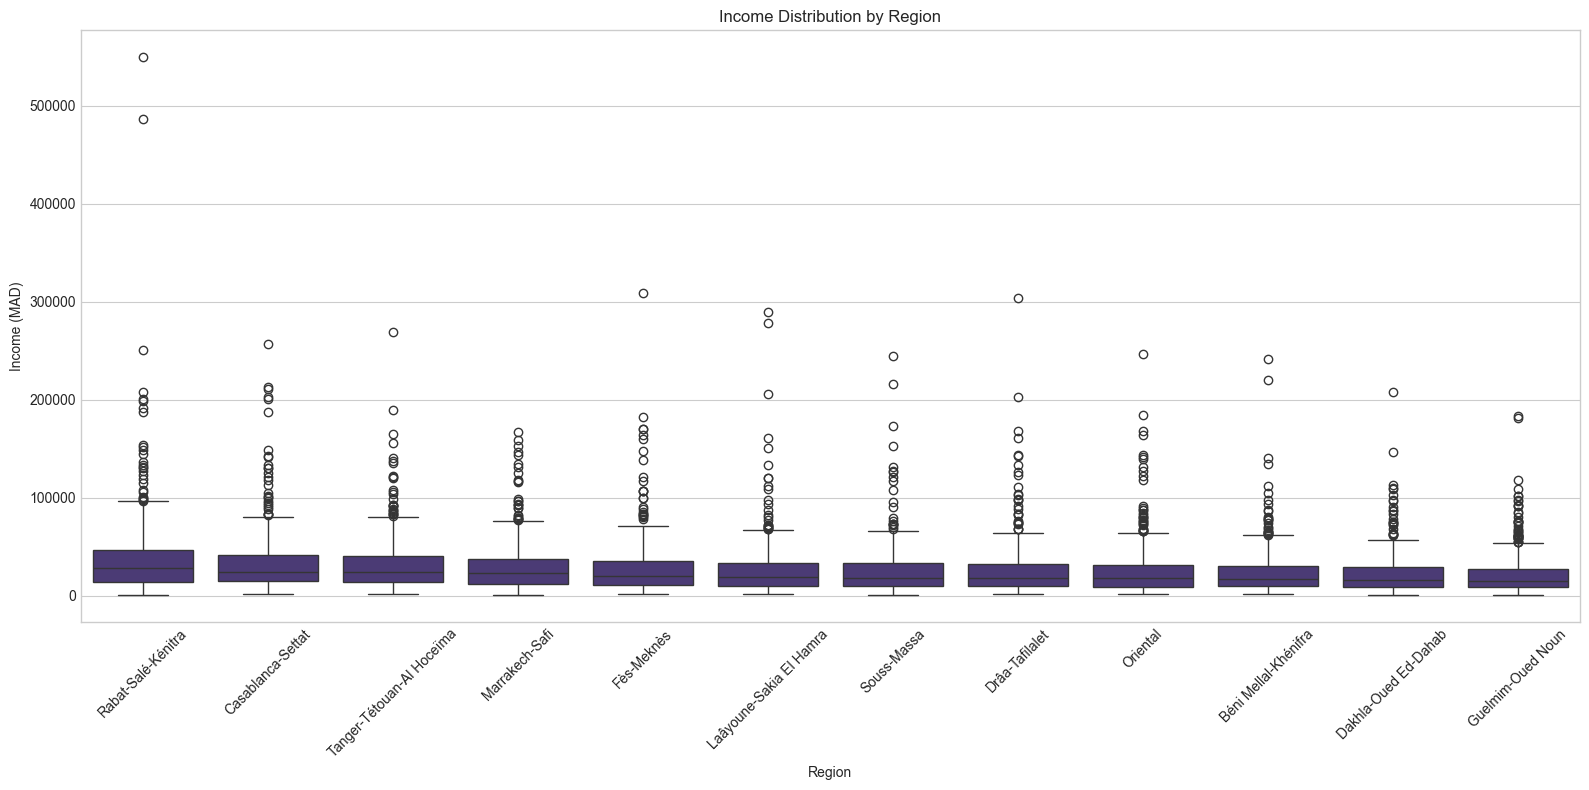


Map visualization would be implemented here with actual geojson data for Morocco's regions.
This would show a choropleth map of mean incomes across different regions.

### Income vs Education Level ###


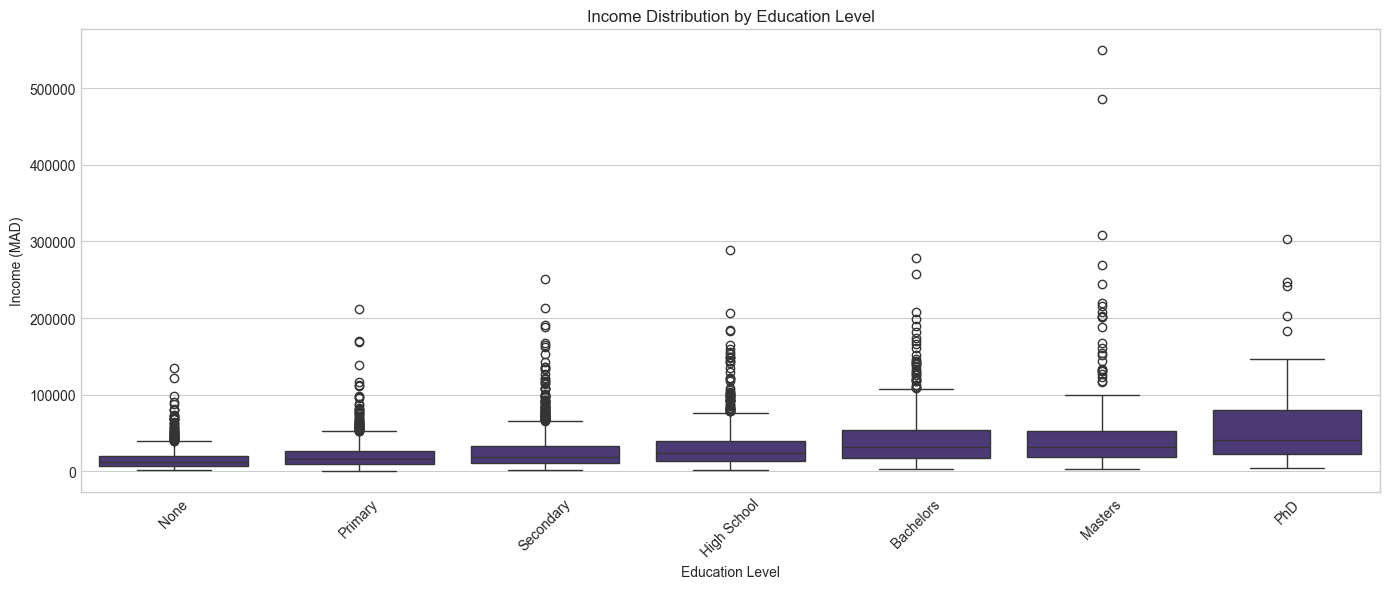

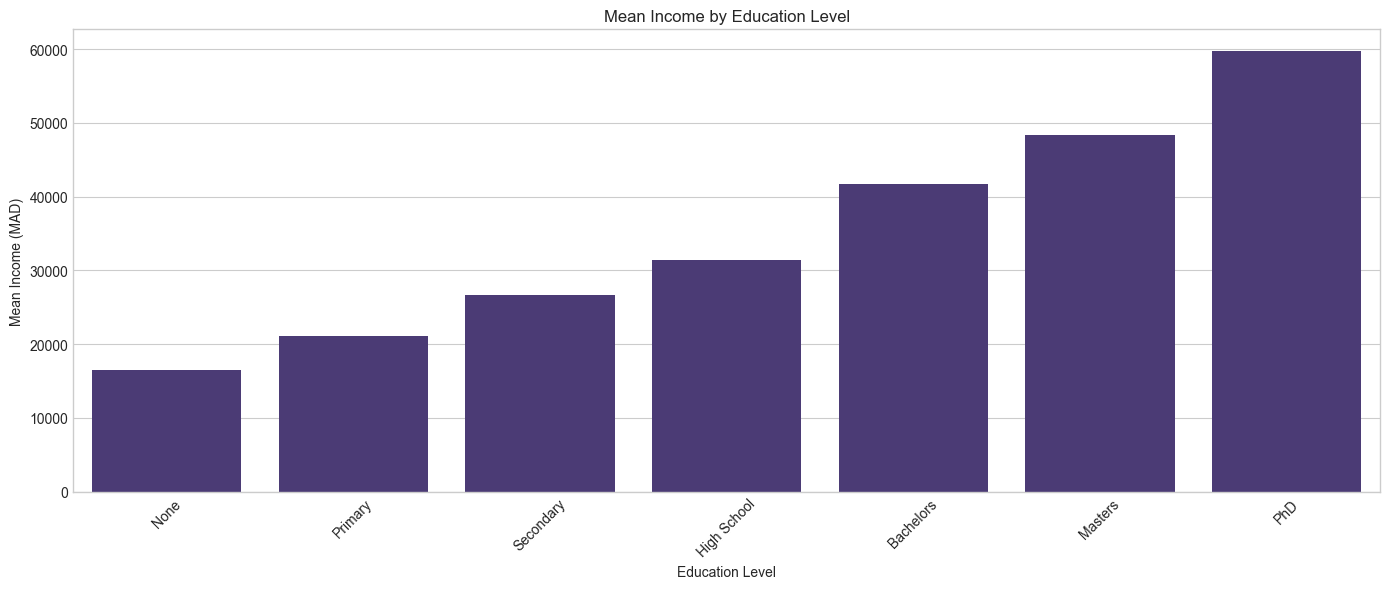


### Income vs Gender ###


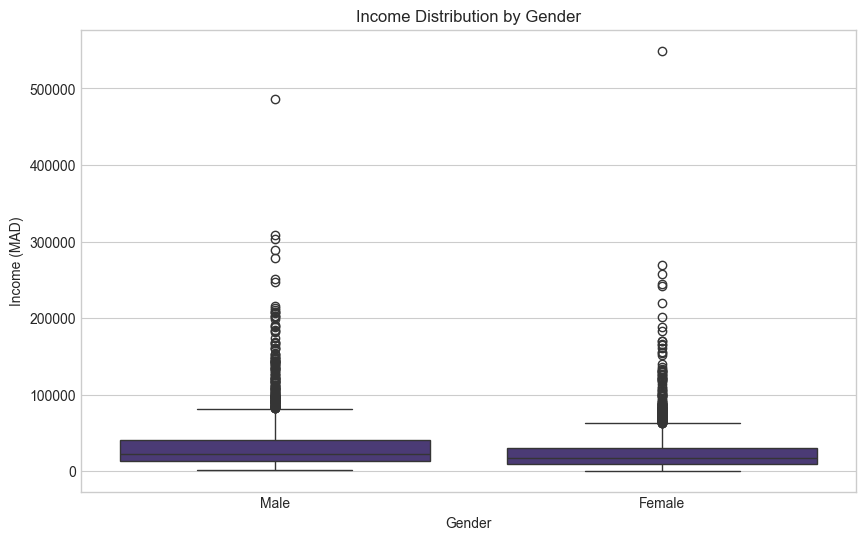

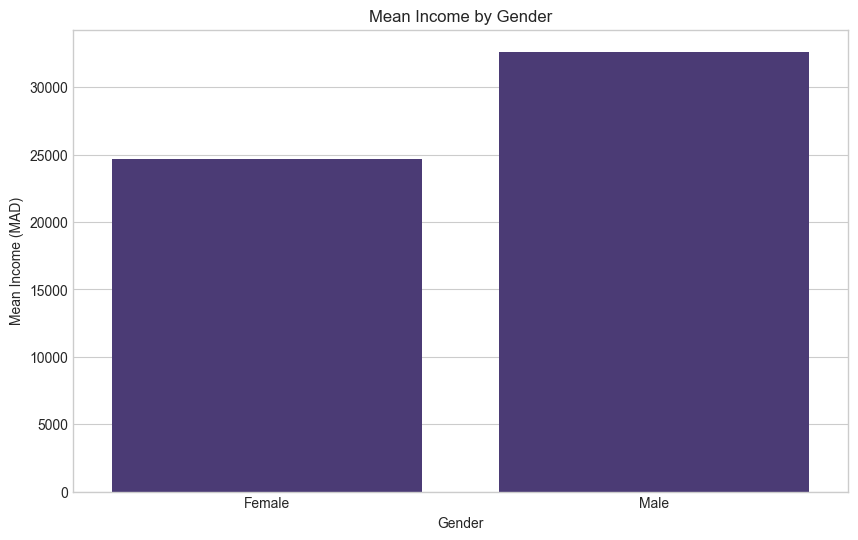


Gender income gap: Males earn approximately 32.5% more than females on average


<Figure size 1400x600 with 0 Axes>

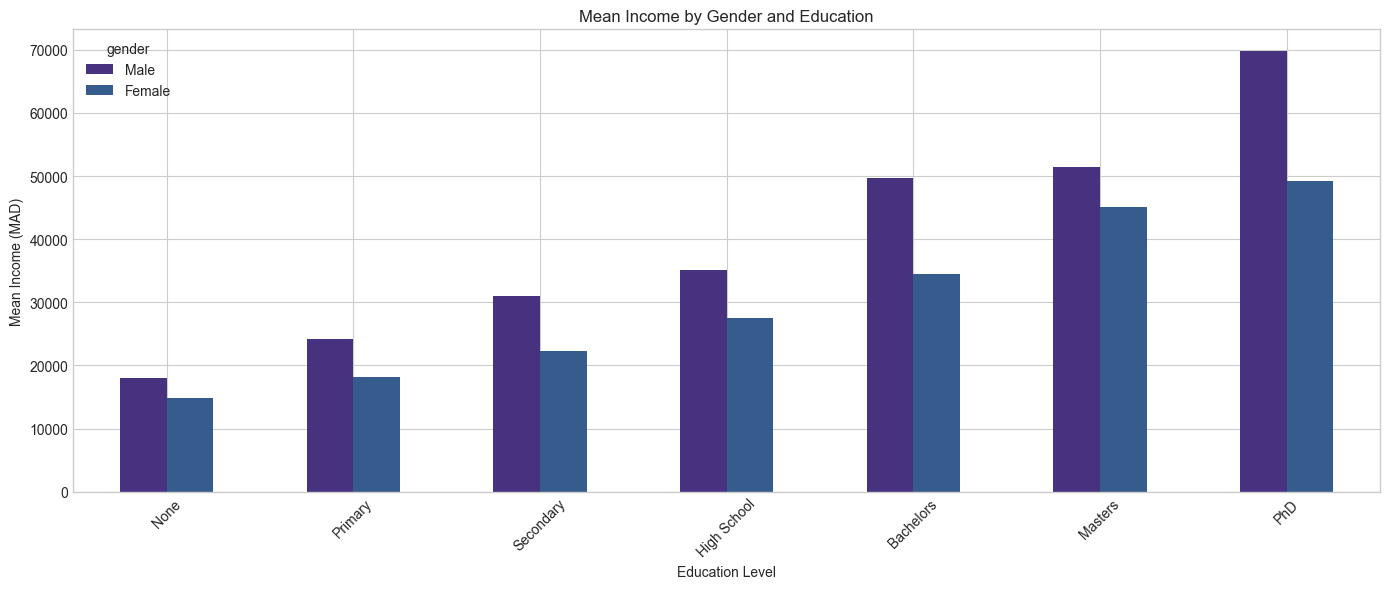

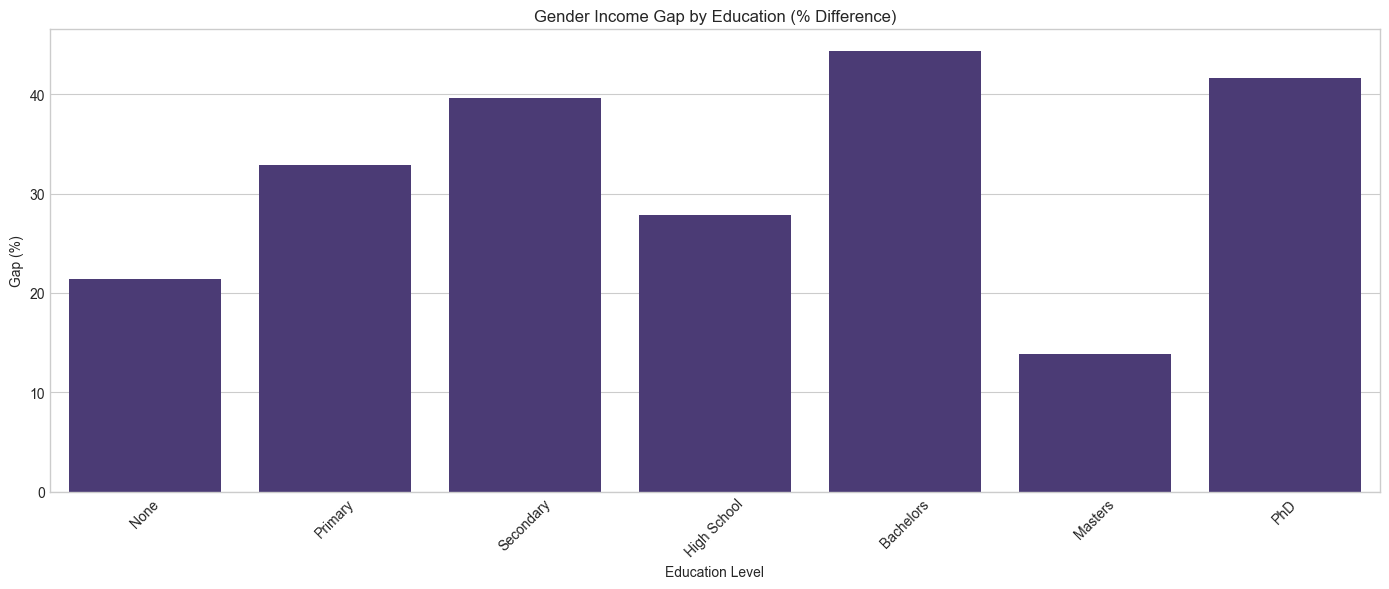


### Urban vs Rural Income Comparison ###


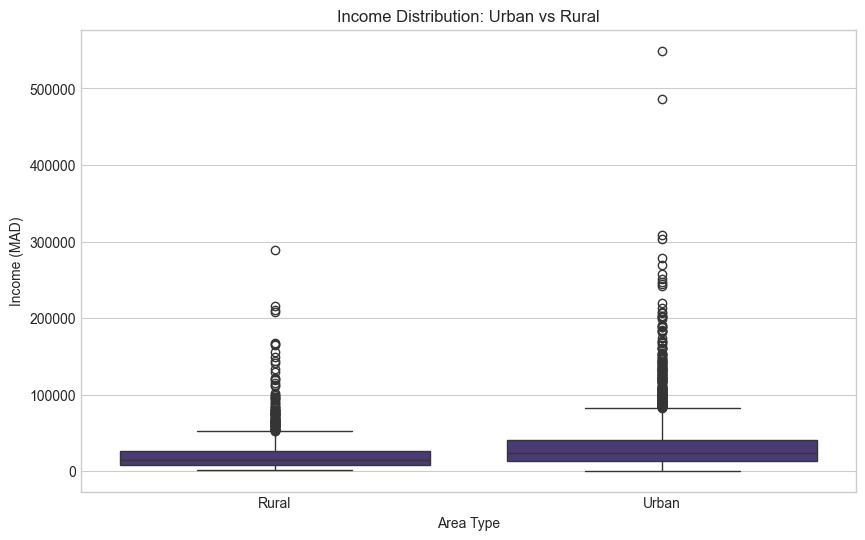

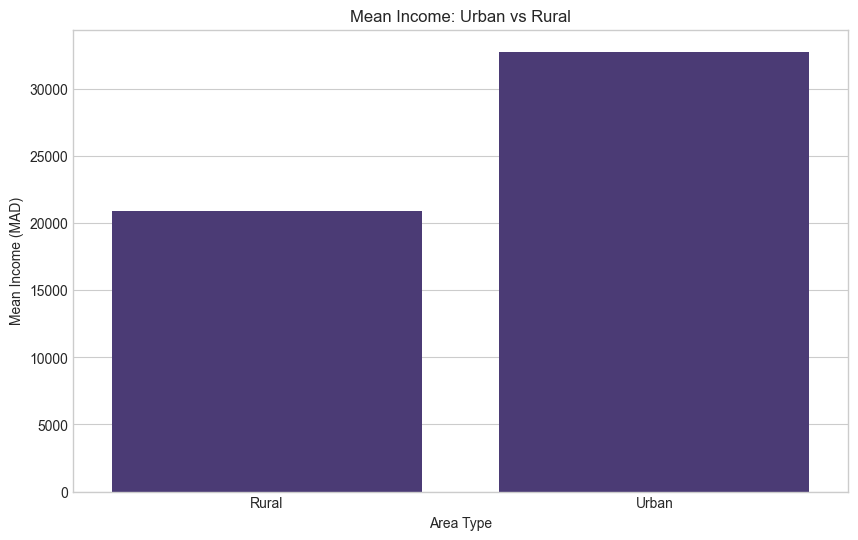


Urban-Rural income gap: Urban residents earn approximately 57.0% more than rural residents on average

### Income by Employment Sector ###


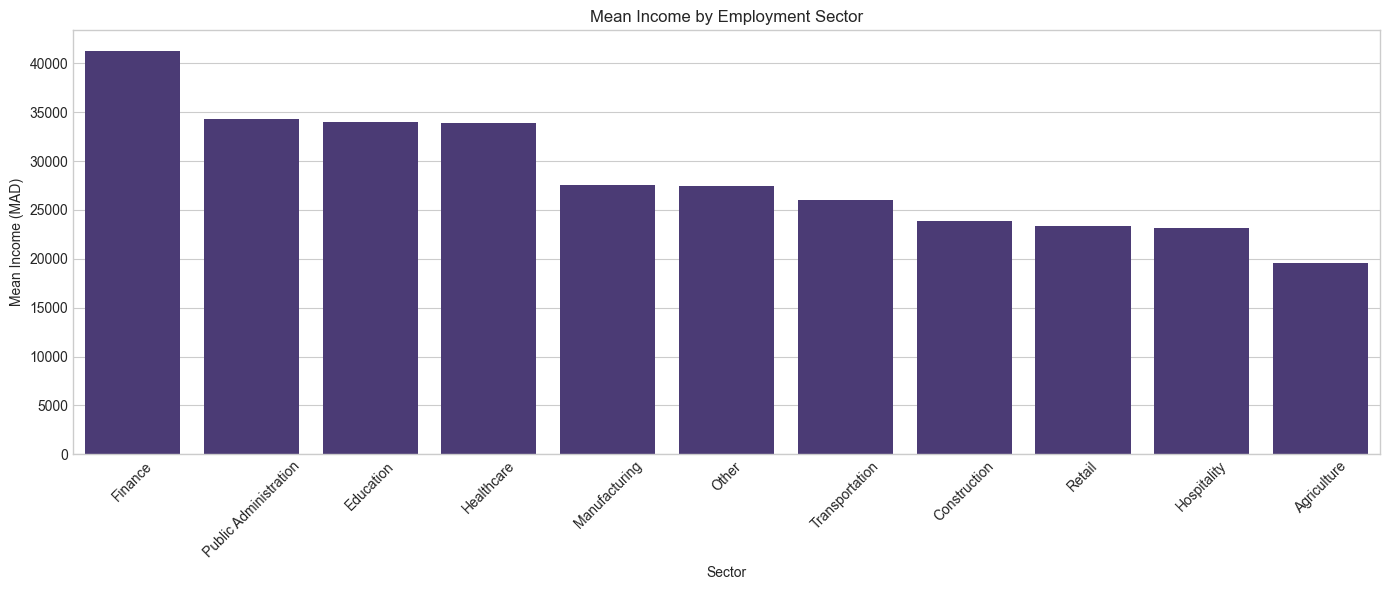

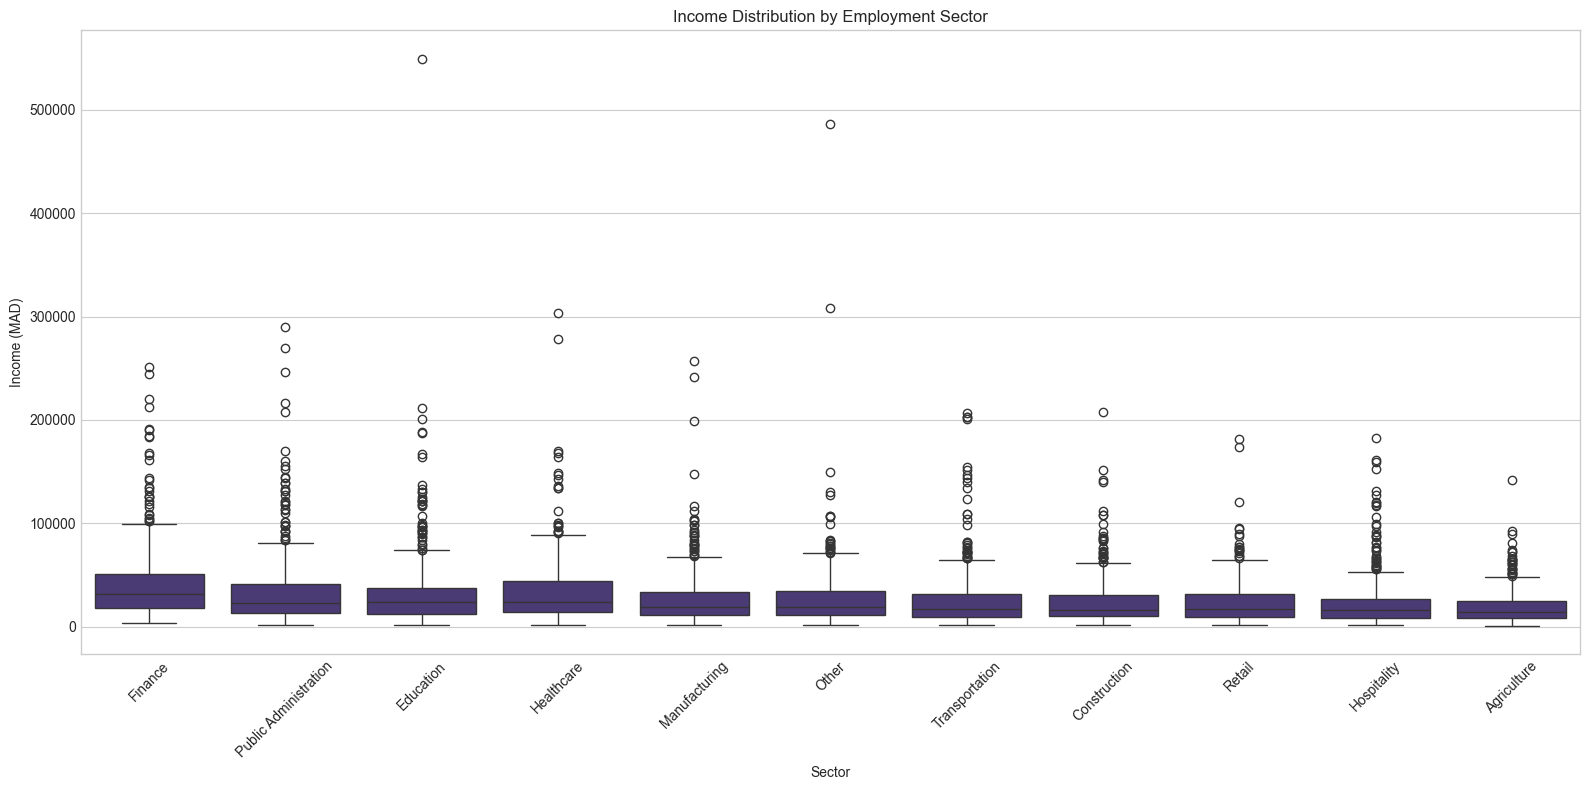


### Income by Occupation ###


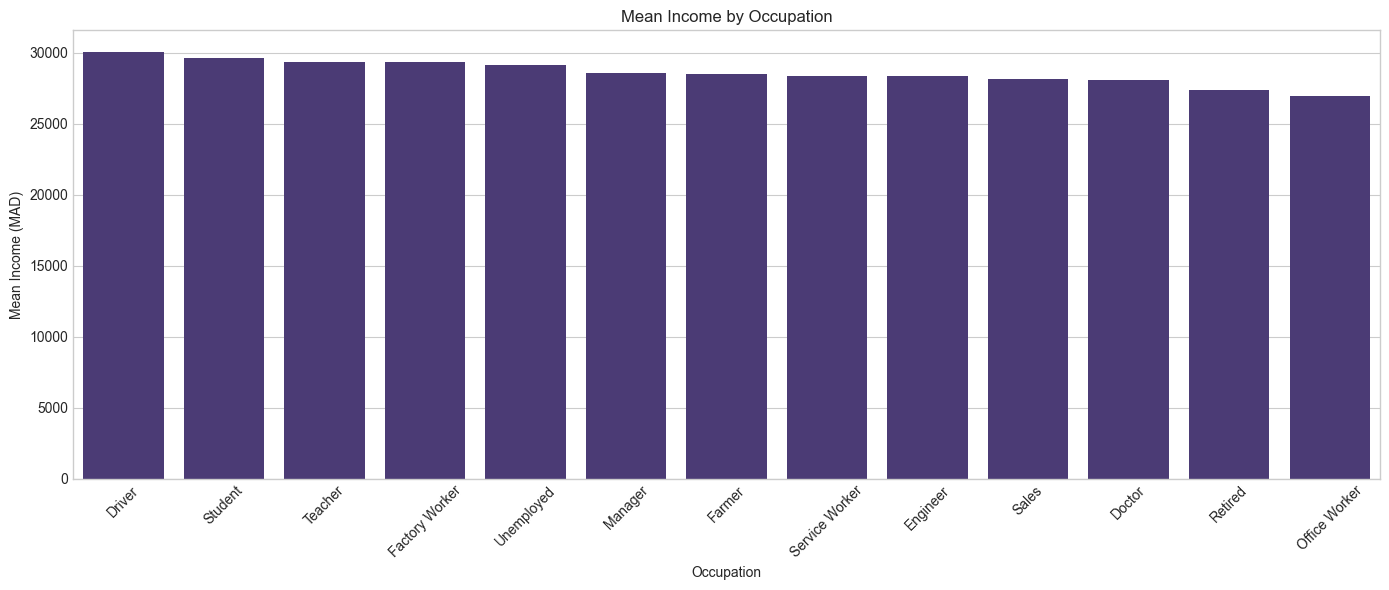

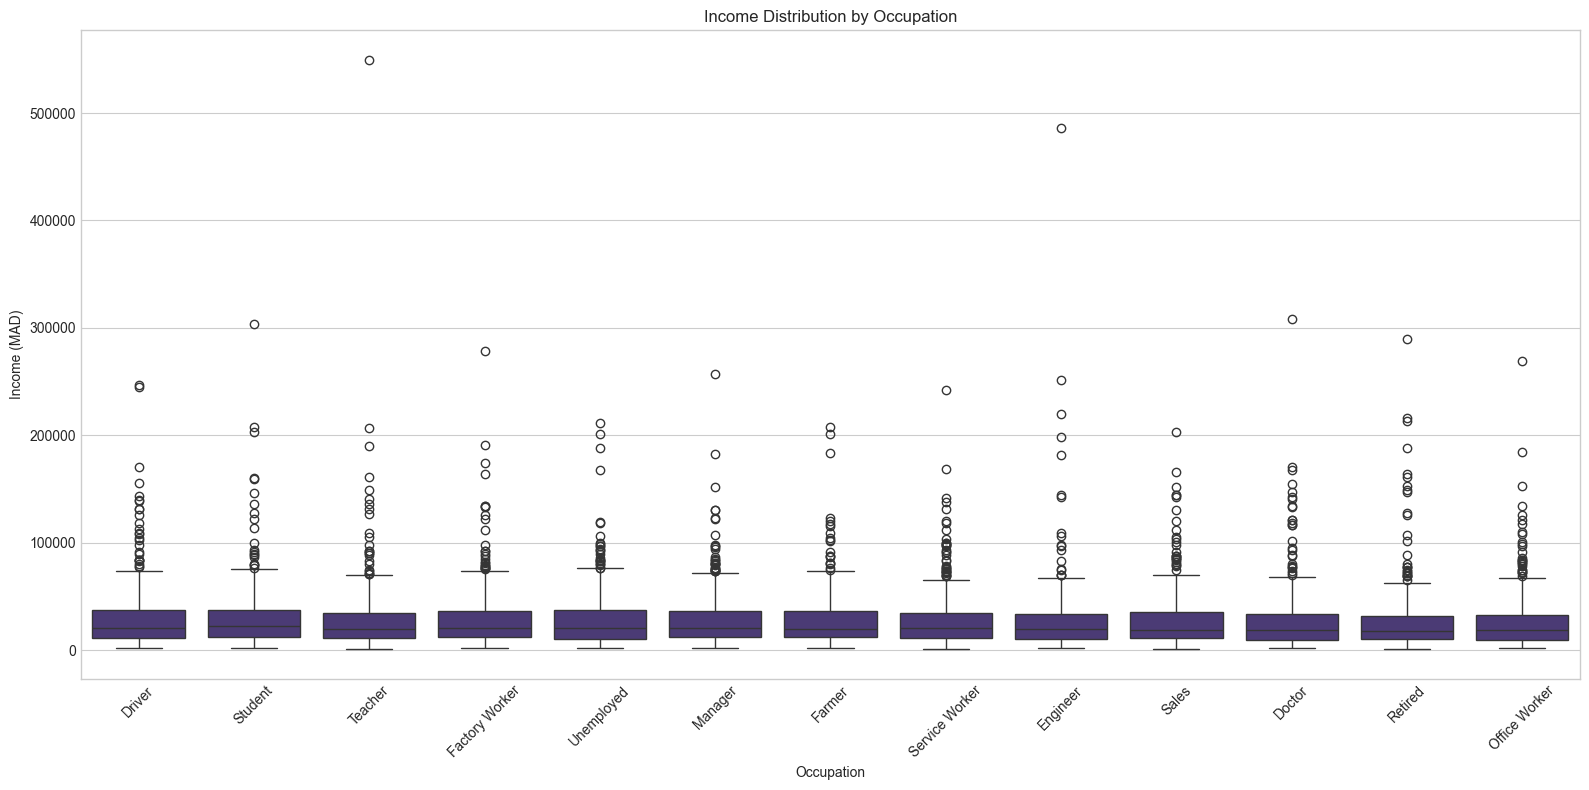


### Income vs Household Size ###


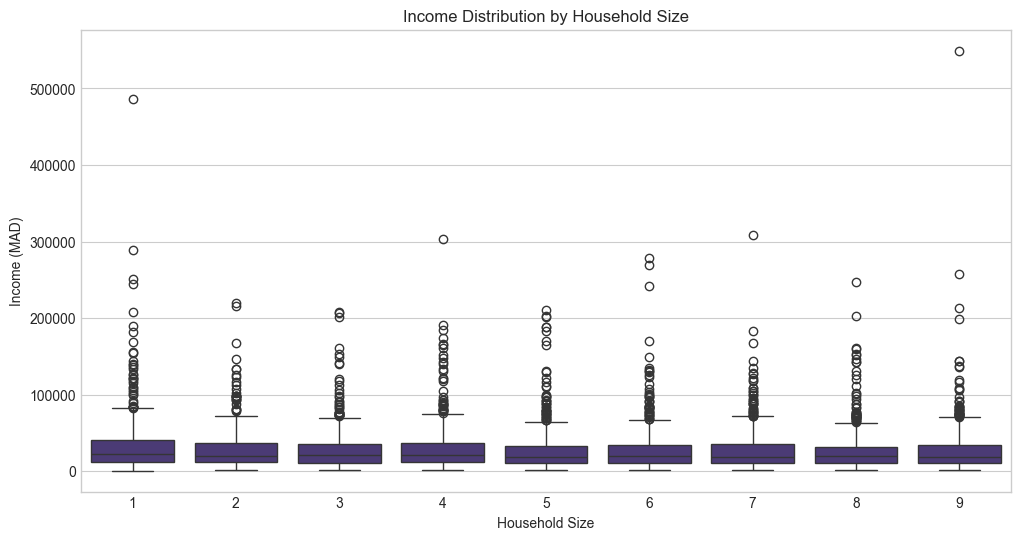

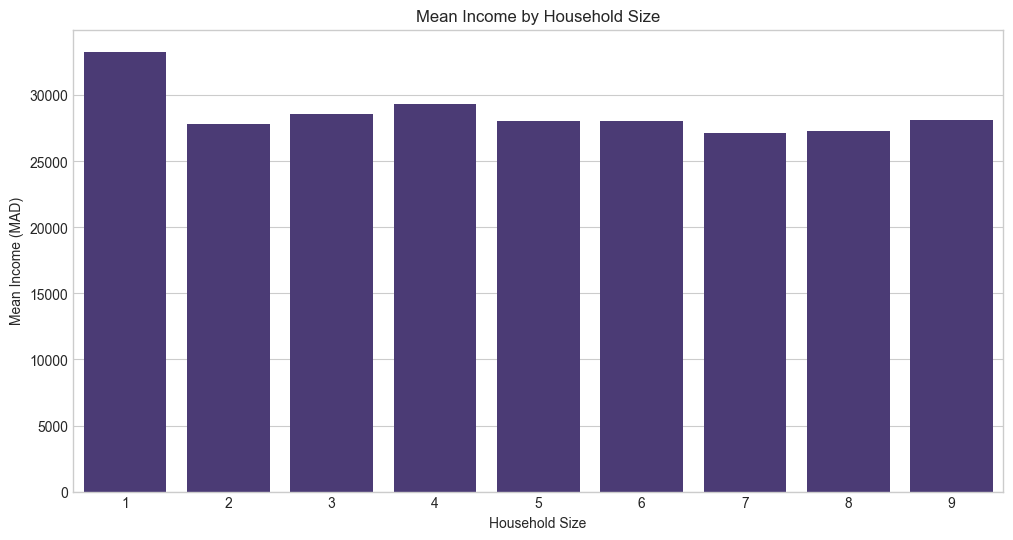


### Income vs Marital Status ###


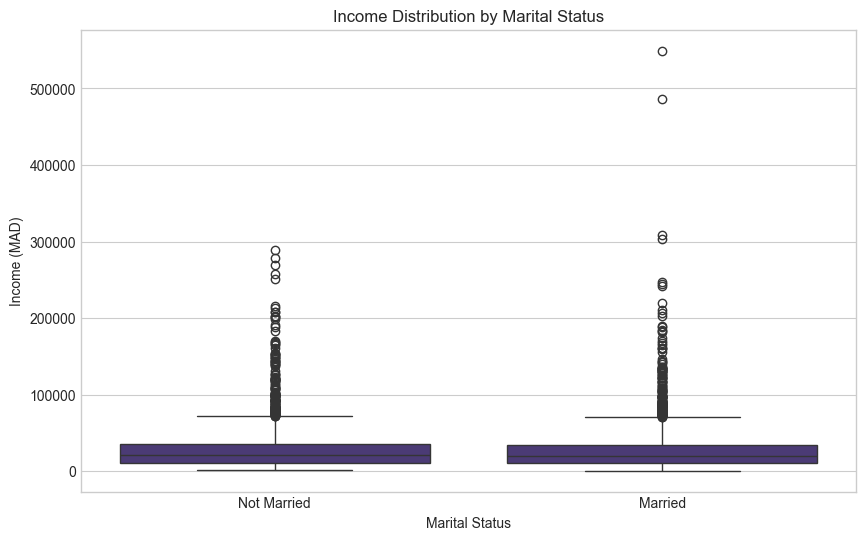

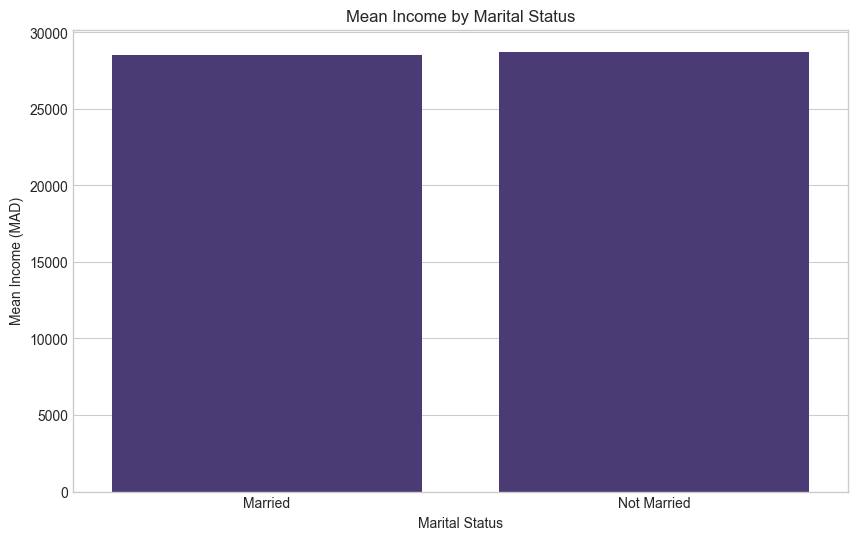


### Income vs Number of Children ###


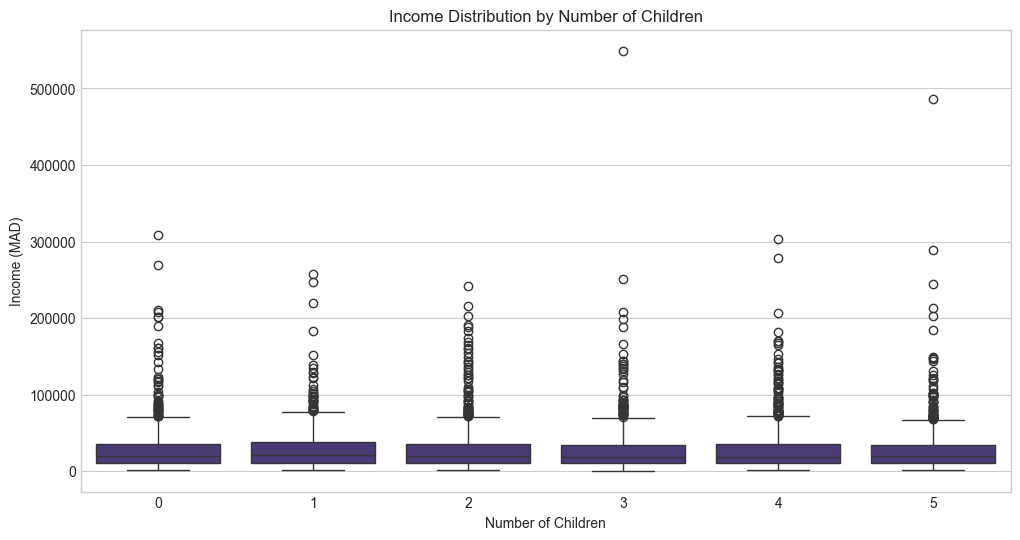

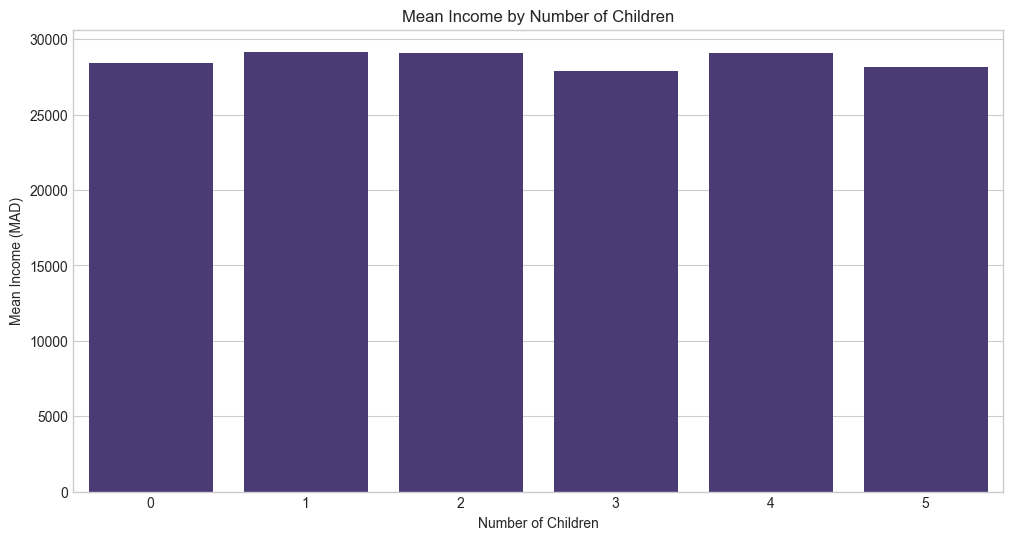

In [ ]:
print("## Bivariate Analysis ##")

# 4.1 Income vs Numerical Features
print("\n### Income vs Age ###")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='age', y='income', alpha=0.5)
plt.title('Income vs Age')
plt.xlabel('Age')
plt.ylabel('Income (MAD)')
plt.show()

# Income by age group
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='age_group', y='income')
plt.title('Income Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Income (MAD)')
plt.show()

# Mean income by age group
age_income = df.groupby('age_group')['income'].agg(['mean', 'median', 'count']).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=age_income, x='age_group', y='mean')
plt.title('Mean Income by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Mean Income (MAD)')
plt.show()

if 'years_experience' in df.columns:
    print("\n### Income vs Years of Experience ###")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='years_experience', y='income', alpha=0.5)
    plt.title('Income vs Years of Experience')
    plt.xlabel('Years of Experience')
    plt.ylabel('Income (MAD)')
    plt.show()
    
    # Experience binned
    df['exp_group'] = pd.cut(df['years_experience'], bins=[0, 5, 10, 15, 20, 30, 100], 
                            labels=['0-5', '6-10', '11-15', '16-20', '21-30', '30+'])
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='exp_group', y='income')
    plt.title('Income Distribution by Years of Experience')
    plt.xlabel('Years of Experience')
    plt.ylabel('Income (MAD)')
    plt.show()

# 4.2 Income by Region with Maps
print("\n### Income by Region ###")

# Calculate regional income statistics
region_income = df.groupby('region')['income'].agg(['mean', 'median', 'std', 'count']).reset_index()
region_income = region_income.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=region_income, x='region', y='mean')
plt.title('Mean Income by Region')
plt.xlabel('Region')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Box plot by region
plt.figure(figsize=(16, 8))
region_order = region_income['region'].tolist()
sns.boxplot(data=df, x='region', y='income', order=region_order)
plt.title('Income Distribution by Region')
plt.xlabel('Region')
plt.ylabel('Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Map visualization using Plotly
# For a real implementation, we would need geojson data for Morocco's regions
# Here's a placeholder for how it would be implemented
print("\nMap visualization would be implemented here with actual geojson data for Morocco's regions.")
print("This would show a choropleth map of mean incomes across different regions.")

# 4.3 Income by Education Level
print("\n### Income vs Education Level ###")
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x='education', y='income', order=education_order)
plt.title('Income Distribution by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Mean income by education
edu_income = df.groupby('education')['income'].agg(['mean', 'median', 'count']).reset_index()
# Ensure proper order
edu_income['education'] = pd.Categorical(edu_income['education'], categories=education_order, ordered=True)
edu_income = edu_income.sort_values('education')

plt.figure(figsize=(14, 6))
sns.barplot(data=edu_income, x='education', y='mean')
plt.title('Mean Income by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.4 Gender-based Income Analysis
print("\n### Income vs Gender ###")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='gender', y='income')
plt.title('Income Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Income (MAD)')
plt.show()

# Mean income by gender
gender_income = df.groupby('gender')['income'].agg(['mean', 'median', 'count']).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=gender_income, x='gender', y='mean')
plt.title('Mean Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Mean Income (MAD)')
plt.show()

# Gender income gap
gender_gap = ((gender_income.loc[gender_income['gender'] == 'Male', 'mean'].values[0] / 
              gender_income.loc[gender_income['gender'] == 'Female', 'mean'].values[0]) - 1) * 100
print(f"\nGender income gap: Males earn approximately {gender_gap:.1f}% more than females on average")

# Gender gap by education
gender_edu_income = df.groupby(['gender', 'education'])['income'].mean().reset_index()
gender_edu_pivot = gender_edu_income.pivot(index='education', columns='gender', values='income')
gender_edu_pivot['gap'] = (gender_edu_pivot['Male'] / gender_edu_pivot['Female'] - 1) * 100

# Ensure proper order
gender_edu_pivot = gender_edu_pivot.reindex(education_order)

plt.figure(figsize=(14, 6))
gender_edu_pivot[['Male', 'Female']].plot(kind='bar', figsize=(14, 6))
plt.title('Mean Income by Gender and Education')
plt.xlabel('Education Level')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.barplot(x=gender_edu_pivot.index, y=gender_edu_pivot['gap'])
plt.title('Gender Income Gap by Education (% Difference)')
plt.xlabel('Education Level')
plt.ylabel('Gap (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.5 Urban vs Rural Analysis
print("\n### Urban vs Rural Income Comparison ###")
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='urban_rural', y='income')
plt.title('Income Distribution: Urban vs Rural')
plt.xlabel('Area Type')
plt.ylabel('Income (MAD)')
plt.show()

# Mean income by area type
area_income = df.groupby('urban_rural')['income'].agg(['mean', 'median', 'count']).reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(data=area_income, x='urban_rural', y='mean')
plt.title('Mean Income: Urban vs Rural')
plt.xlabel('Area Type')
plt.ylabel('Mean Income (MAD)')
plt.show()

# Urban-Rural gap
urban_rural_gap = ((area_income.loc[area_income['urban_rural'] == 'Urban', 'mean'].values[0] / 
                  area_income.loc[area_income['urban_rural'] == 'Rural', 'mean'].values[0]) - 1) * 100
print(f"\nUrban-Rural income gap: Urban residents earn approximately {urban_rural_gap:.1f}% more than rural residents on average")

# 4.6 Income by Sector and Occupation
print("\n### Income by Employment Sector ###")
sector_income = df.groupby('sector')['income'].agg(['mean', 'median', 'count']).reset_index()
sector_income = sector_income.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=sector_income, x='sector', y='mean')
plt.title('Mean Income by Employment Sector')
plt.xlabel('Sector')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
sector_order = sector_income['sector'].tolist()
sns.boxplot(data=df, x='sector', y='income', order=sector_order)
plt.title('Income Distribution by Employment Sector')
plt.xlabel('Sector')
plt.ylabel('Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n### Income by Occupation ###")
occupation_income = df.groupby('occupation')['income'].agg(['mean', 'median', 'count']).reset_index()
occupation_income = occupation_income.sort_values('mean', ascending=False)

plt.figure(figsize=(14, 6))
sns.barplot(data=occupation_income, x='occupation', y='mean')
plt.title('Mean Income by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(16, 8))
occupation_order = occupation_income['occupation'].tolist()
sns.boxplot(data=df, x='occupation', y='income', order=occupation_order)
plt.title('Income Distribution by Occupation')
plt.xlabel('Occupation')
plt.ylabel('Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4.7 Family structure vs income if available
if 'household_size' in df.columns:
    print("\n### Income vs Household Size ###")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='household_size', y='income')
    plt.title('Income Distribution by Household Size')
    plt.xlabel('Household Size')
    plt.ylabel('Income (MAD)')
    plt.show()
    
    household_income = df.groupby('household_size')['income'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=household_income, x='household_size', y='income')
    plt.title('Mean Income by Household Size')
    plt.xlabel('Household Size')
    plt.ylabel('Mean Income (MAD)')
    plt.show()

if 'married' in df.columns:
    print("\n### Income vs Marital Status ###")
    df['marital_status'] = df['married'].map({1: 'Married', 0: 'Not Married'})
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df, x='marital_status', y='income')
    plt.title('Income Distribution by Marital Status')
    plt.xlabel('Marital Status')
    plt.ylabel('Income (MAD)')
    plt.show()
    
    marital_income = df.groupby('marital_status')['income'].agg(['mean', 'median']).reset_index()
    plt.figure(figsize=(10, 6))
    sns.barplot(data=marital_income, x='marital_status', y='mean')
    plt.title('Mean Income by Marital Status')
    plt.xlabel('Marital Status')
    plt.ylabel('Mean Income (MAD)')
    plt.show()

if 'children' in df.columns:
    print("\n### Income vs Number of Children ###")
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df, x='children', y='income')
    plt.title('Income Distribution by Number of Children')
    plt.xlabel('Number of Children')
    plt.ylabel('Income (MAD)')
    plt.show()
    
    children_income = df.groupby('children')['income'].mean().reset_index()
    plt.figure(figsize=(12, 6))
    sns.barplot(data=children_income, x='children', y='income')
    plt.title('Mean Income by Number of Children')
    plt.xlabel('Number of Children')
    plt.ylabel('Mean Income (MAD)')
    plt.show()

## 5. Multivariate Analysis

Let's explore how multiple variables interact with each other and with income.

## Multivariate Analysis ##

### Correlation Analysis ###


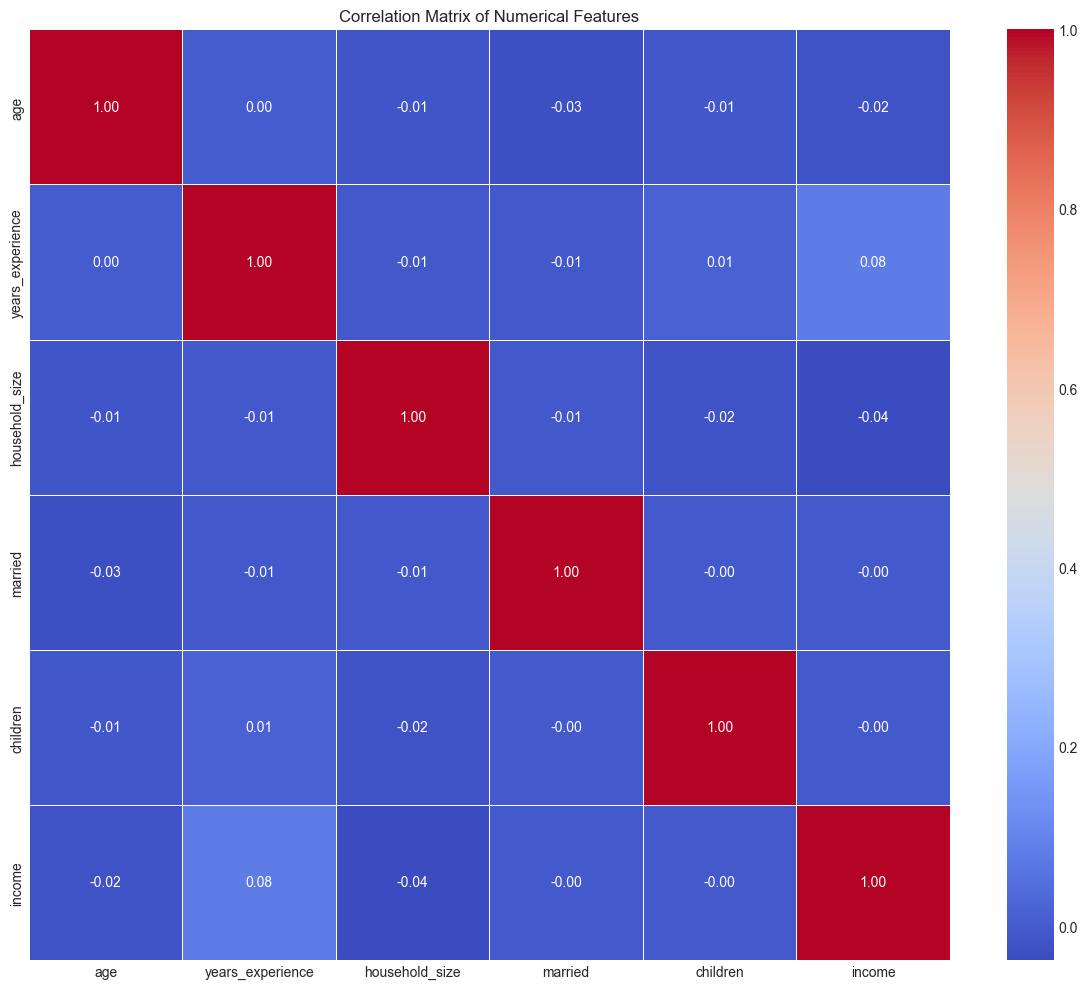


### Education, Gender and Income ###


<Figure size 1400x600 with 0 Axes>

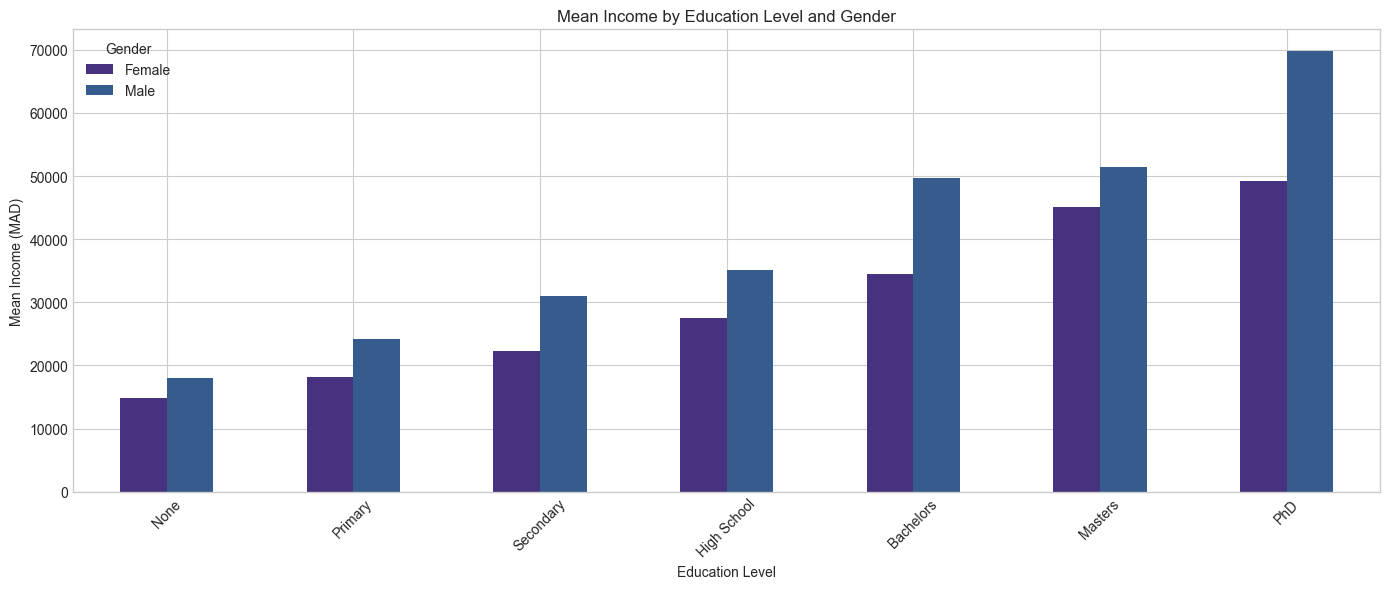


### Region, Urban/Rural and Income ###


<Figure size 1400x800 with 0 Axes>

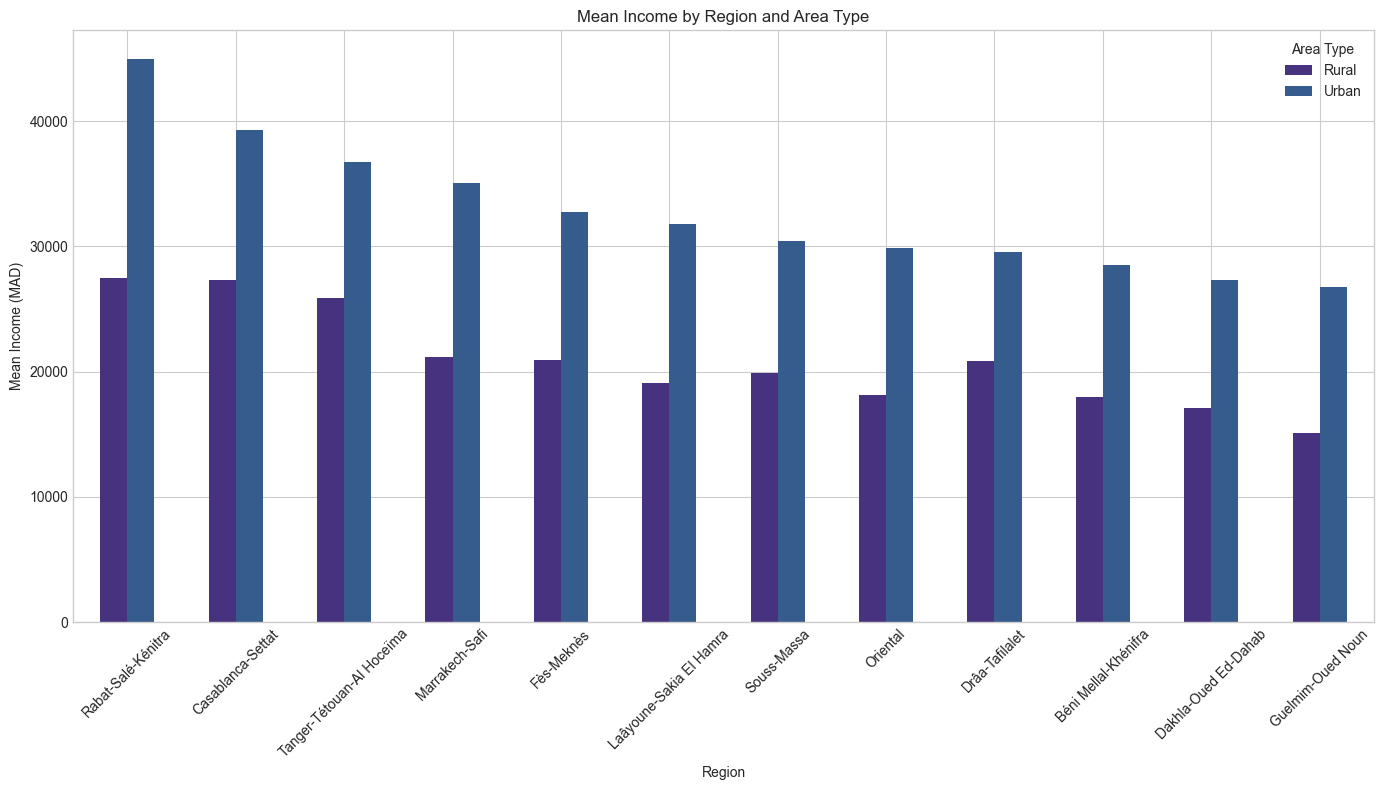

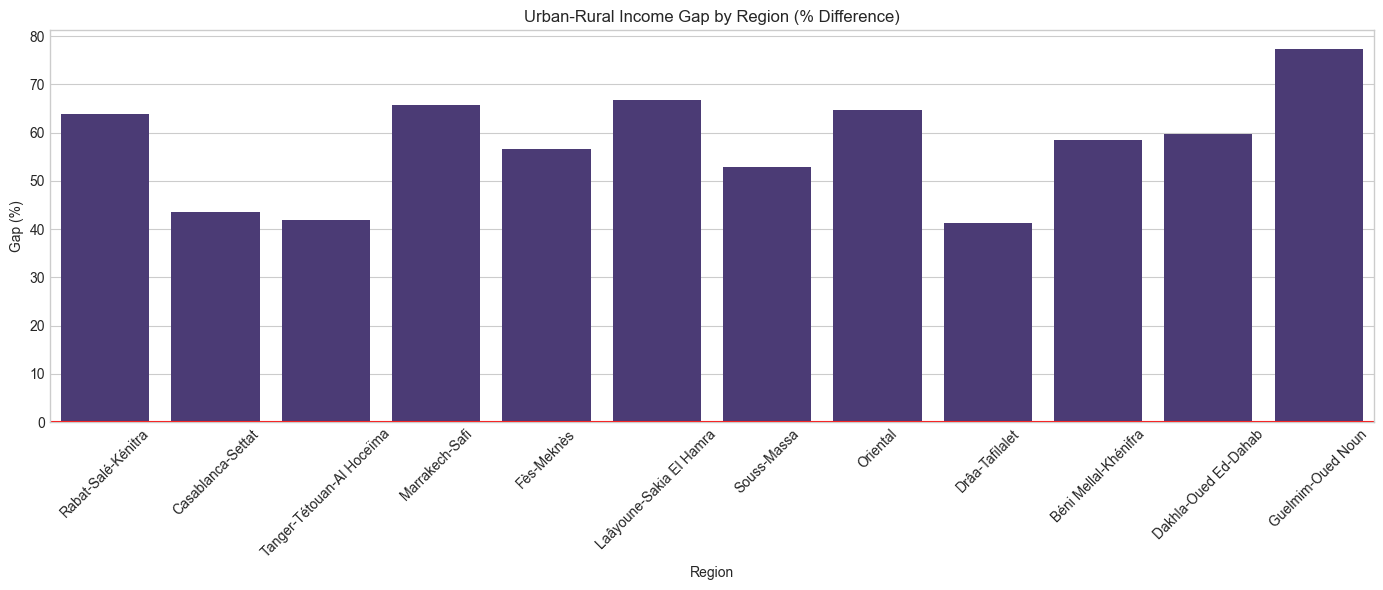


### Education, Sector and Income ###


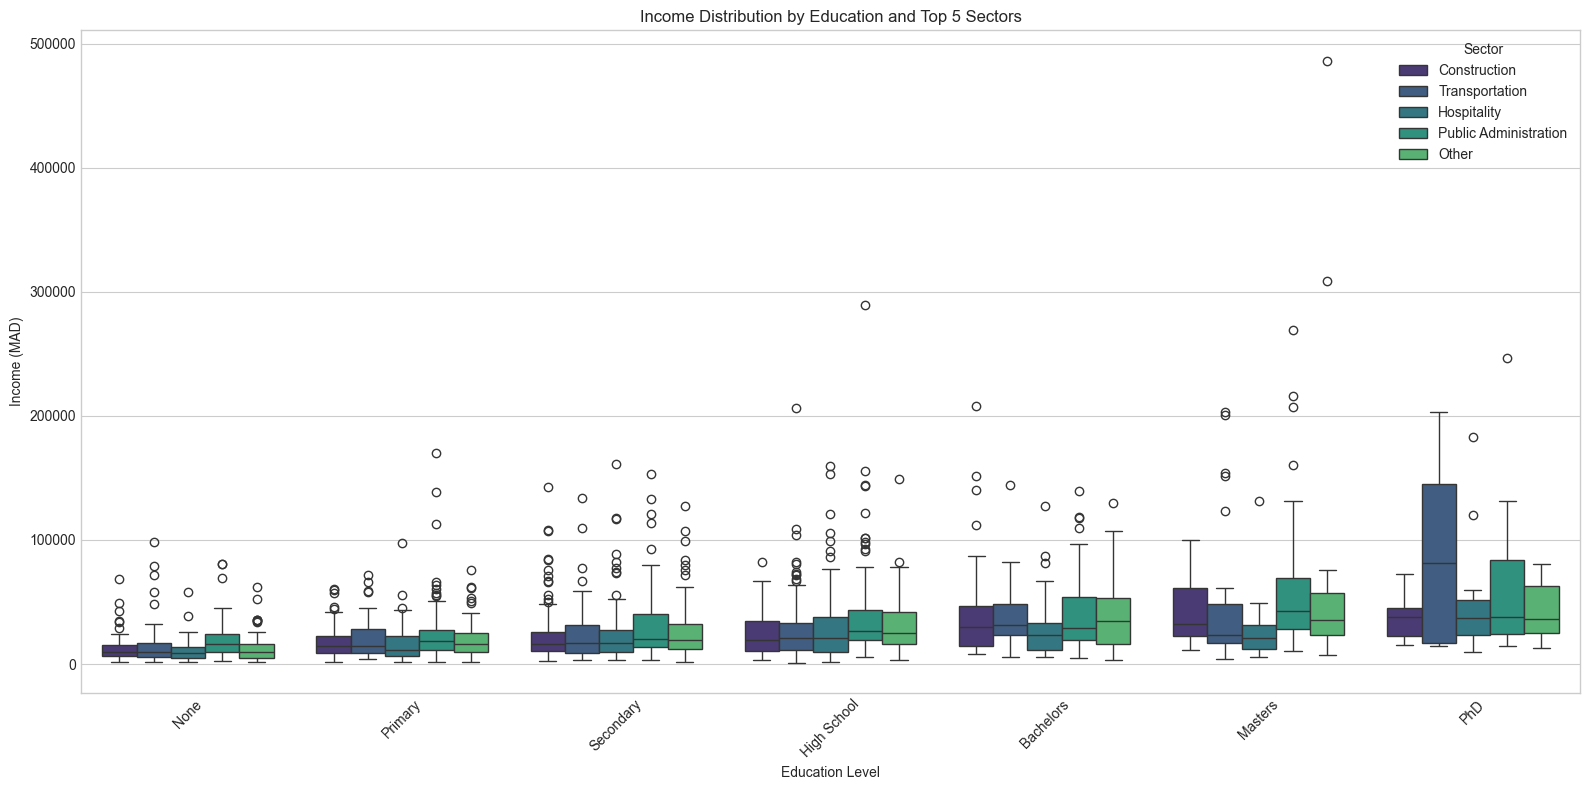

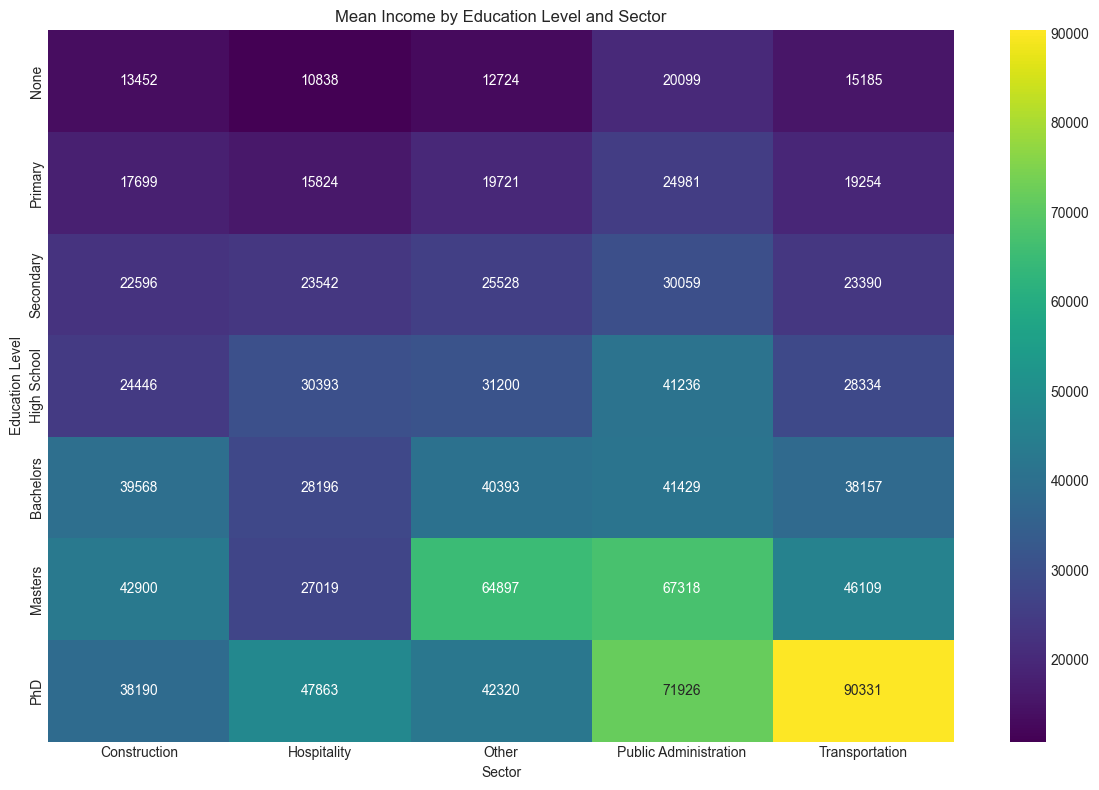


### Age, Gender and Income ###


<Figure size 1200x600 with 0 Axes>

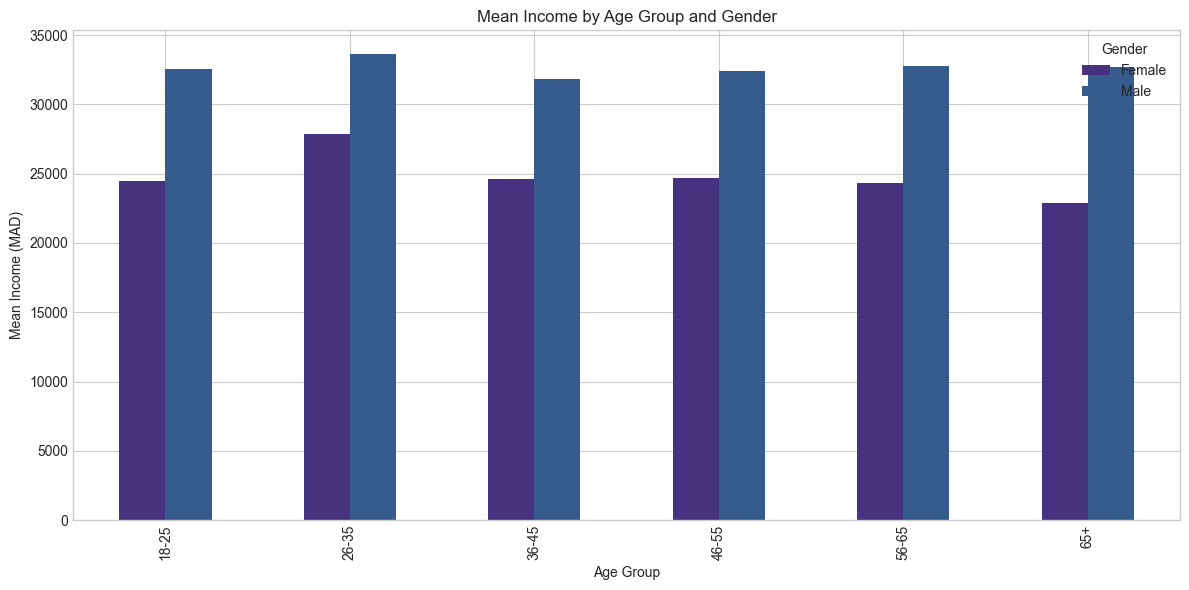

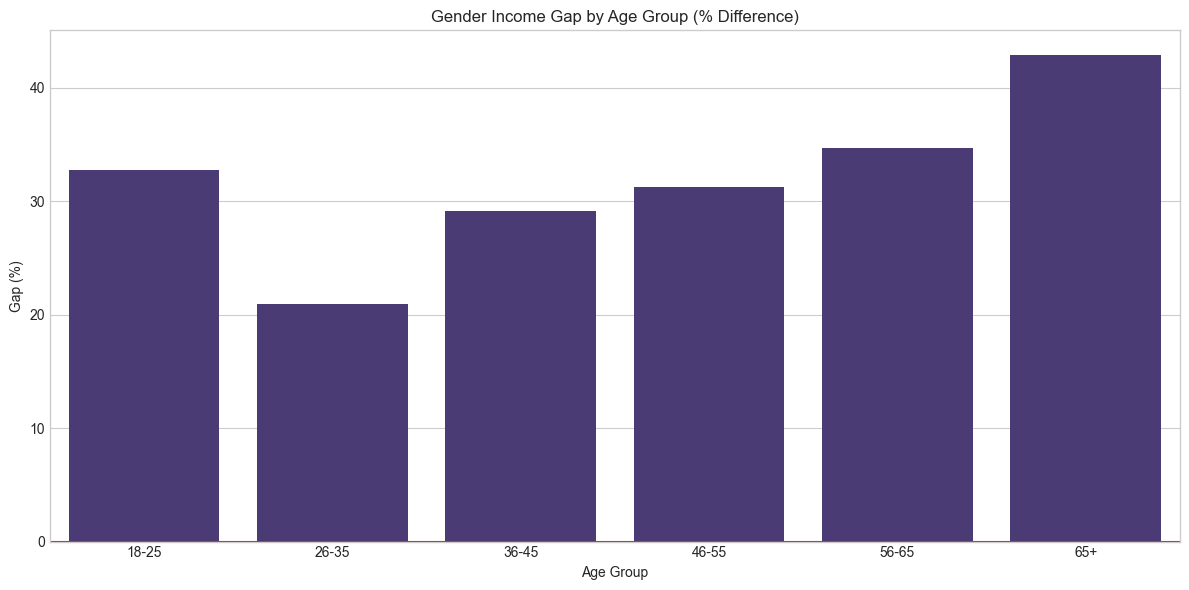


### Education, Urban/Rural and Income ###


<Figure size 1400x600 with 0 Axes>

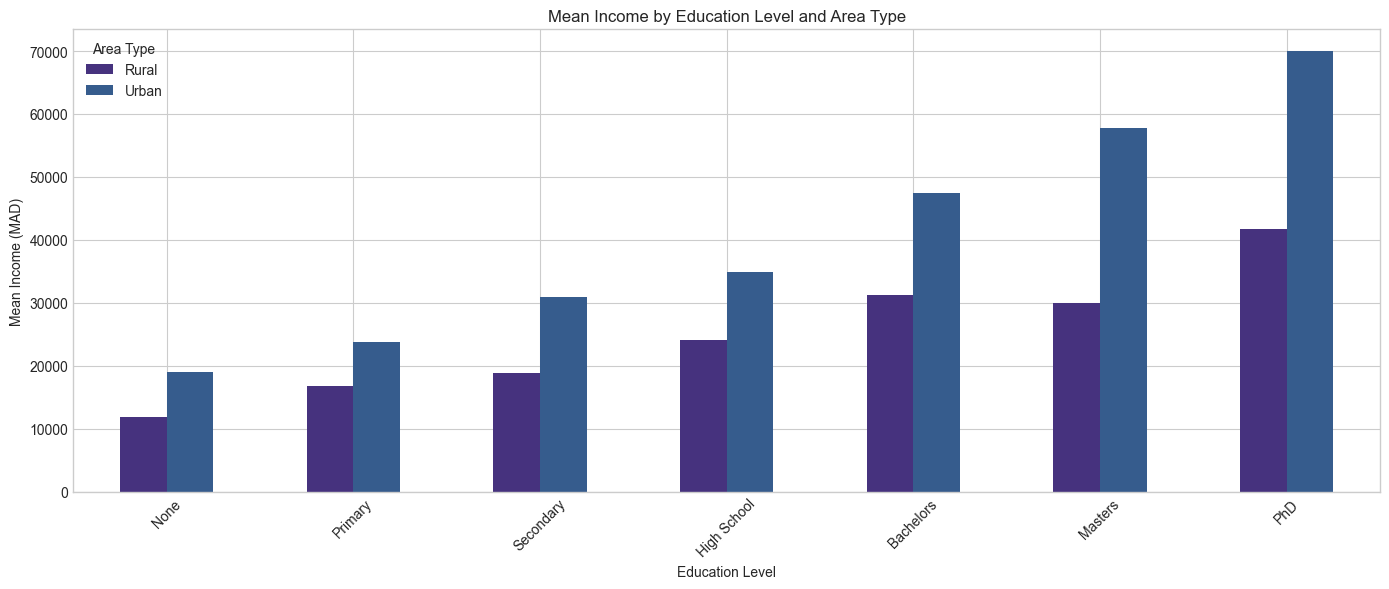

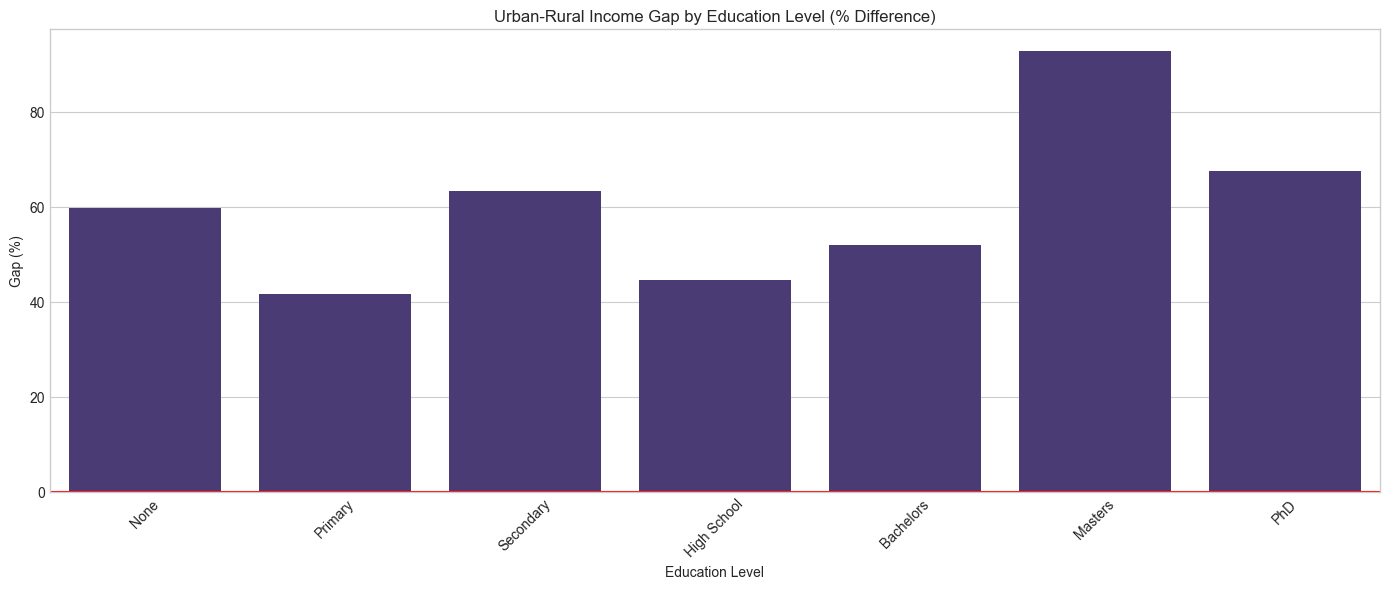


### Conditional Income Distributions ###


<Figure size 1400x600 with 0 Axes>

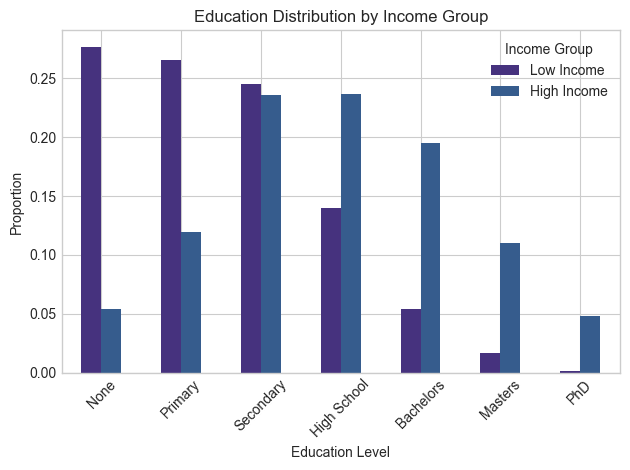

<Figure size 1400x600 with 0 Axes>

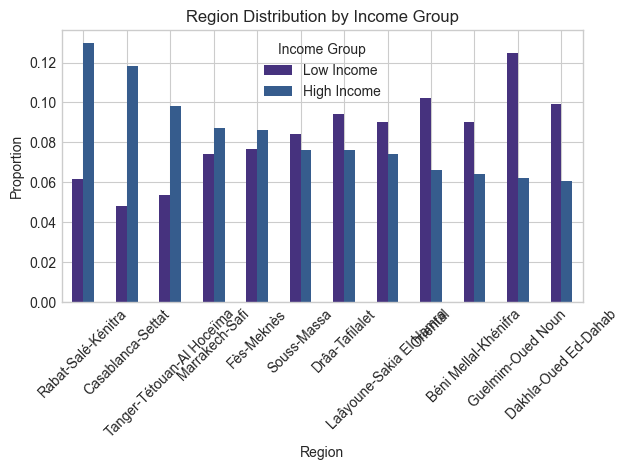

<Figure size 1400x600 with 0 Axes>

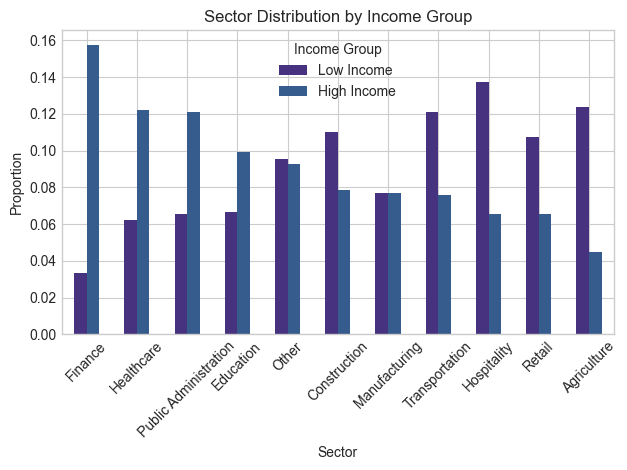

In [ ]:
print("## Multivariate Analysis ##")

# 5.1 Correlation Matrix
print("\n### Correlation Analysis ###")

# Select numeric columns for correlation analysis
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = df[numeric_cols].corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

# 5.2 Education, Gender and Income
print("\n### Education, Gender and Income ###")
edu_gender_income = df.groupby(['education', 'gender'])['income'].mean().reset_index()
edu_gender_pivot = edu_gender_income.pivot(index='education', columns='gender', values='income')

# Ensure proper order
edu_gender_pivot = edu_gender_pivot.reindex(education_order)

plt.figure(figsize=(14, 6))
edu_gender_pivot.plot(kind='bar', figsize=(14, 6))
plt.title('Mean Income by Education Level and Gender')
plt.xlabel('Education Level')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Gender')
plt.show()

# 5.3 Region, Urban/Rural and Income
print("\n### Region, Urban/Rural and Income ###")
region_area_income = df.groupby(['region', 'urban_rural'])['income'].mean().reset_index()
region_area_pivot = region_area_income.pivot(index='region', columns='urban_rural', values='income')

# Sort by Urban income
region_area_pivot = region_area_pivot.sort_values(by='Urban', ascending=False)

plt.figure(figsize=(14, 8))
region_area_pivot.plot(kind='bar', figsize=(14, 8))
plt.title('Mean Income by Region and Area Type')
plt.xlabel('Region')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Area Type')
plt.show()

# Urban-Rural gap by region
region_area_pivot['gap'] = (region_area_pivot['Urban'] / region_area_pivot['Rural'] - 1) * 100
plt.figure(figsize=(14, 6))
sns.barplot(x=region_area_pivot.index, y=region_area_pivot['gap'])
plt.title('Urban-Rural Income Gap by Region (% Difference)')
plt.xlabel('Region')
plt.ylabel('Gap (%)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

# 5.4 Education, Sector and Income
print("\n### Education, Sector and Income ###")
# We'll focus on the most common sectors and education levels for clarity
top_sectors = df['sector'].value_counts().nlargest(5).index.tolist()
edu_sector_df = df[df['sector'].isin(top_sectors)]

plt.figure(figsize=(16, 8))
sns.boxplot(data=edu_sector_df, x='education', y='income', hue='sector', order=education_order)
plt.title('Income Distribution by Education and Top 5 Sectors')
plt.xlabel('Education Level')
plt.ylabel('Income (MAD)')
plt.xticks(rotation=45)
plt.legend(title='Sector')
plt.tight_layout()
plt.show()

# Mean income by education and sector
edu_sector_income = edu_sector_df.groupby(['education', 'sector'])['income'].mean().reset_index()

# Plot as a heatmap
edu_sector_pivot = edu_sector_income.pivot(index='education', columns='sector', values='income')
edu_sector_pivot = edu_sector_pivot.reindex(education_order)

plt.figure(figsize=(12, 8))
sns.heatmap(edu_sector_pivot, annot=True, cmap='viridis', fmt='.0f')
plt.title('Mean Income by Education Level and Sector')
plt.xlabel('Sector')
plt.ylabel('Education Level')
plt.tight_layout()
plt.show()

# 5.5 Age, Gender and Income
print("\n### Age, Gender and Income ###")
age_gender_income = df.groupby(['age_group', 'gender'])['income'].mean().reset_index()
age_gender_pivot = age_gender_income.pivot(index='age_group', columns='gender', values='income')

plt.figure(figsize=(12, 6))
age_gender_pivot.plot(kind='bar', figsize=(12, 6))
plt.title('Mean Income by Age Group and Gender')
plt.xlabel('Age Group')
plt.ylabel('Mean Income (MAD)')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

# Gender gap by age
age_gender_pivot['gap'] = (age_gender_pivot['Male'] / age_gender_pivot['Female'] - 1) * 100
plt.figure(figsize=(12, 6))
sns.barplot(x=age_gender_pivot.index, y=age_gender_pivot['gap'])
plt.title('Gender Income Gap by Age Group (% Difference)')
plt.xlabel('Age Group')
plt.ylabel('Gap (%)')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

# 5.6 Education, Urban/Rural and Income
print("\n### Education, Urban/Rural and Income ###")
edu_area_income = df.groupby(['education', 'urban_rural'])['income'].mean().reset_index()
edu_area_pivot = edu_area_income.pivot(index='education', columns='urban_rural', values='income')

# Ensure proper order
edu_area_pivot = edu_area_pivot.reindex(education_order)

plt.figure(figsize=(14, 6))
edu_area_pivot.plot(kind='bar', figsize=(14, 6))
plt.title('Mean Income by Education Level and Area Type')
plt.xlabel('Education Level')
plt.ylabel('Mean Income (MAD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Area Type')
plt.show()

# Urban-Rural gap by education
edu_area_pivot['gap'] = (edu_area_pivot['Urban'] / edu_area_pivot['Rural'] - 1) * 100
plt.figure(figsize=(14, 6))
sns.barplot(x=edu_area_pivot.index, y=edu_area_pivot['gap'])
plt.title('Urban-Rural Income Gap by Education Level (% Difference)')
plt.xlabel('Education Level')
plt.ylabel('Gap (%)')
plt.xticks(rotation=45)
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

# 5.7 Conditional Distributions
print("\n### Conditional Income Distributions ###")

# Top vs Bottom Income Analysis
income_quantiles = df['income'].quantile([0.25, 0.75]).values
low_income = df[df['income'] <= income_quantiles[0]]
high_income = df[df['income'] >= income_quantiles[1]]

# Compare education distribution
edu_income_dist = pd.DataFrame({
    'Low Income': low_income['education'].value_counts(normalize=True),
    'High Income': high_income['education'].value_counts(normalize=True)
}).reindex(education_order).fillna(0)

plt.figure(figsize=(14, 6))
edu_income_dist.plot(kind='bar')
plt.title('Education Distribution by Income Group')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Income Group')
plt.tight_layout()
plt.show()

# Compare region distribution
region_income_dist = pd.DataFrame({
    'Low Income': low_income['region'].value_counts(normalize=True),
    'High Income': high_income['region'].value_counts(normalize=True)
}).fillna(0)

# Sort by high income prevalence
region_income_dist = region_income_dist.sort_values('High Income', ascending=False)

plt.figure(figsize=(14, 6))
region_income_dist.plot(kind='bar')
plt.title('Region Distribution by Income Group')
plt.xlabel('Region')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Income Group')
plt.tight_layout()
plt.show()

# Compare sector distribution
sector_income_dist = pd.DataFrame({
    'Low Income': low_income['sector'].value_counts(normalize=True),
    'High Income': high_income['sector'].value_counts(normalize=True)
}).fillna(0)

# Sort by high income prevalence
sector_income_dist = sector_income_dist.sort_values('High Income', ascending=False)

plt.figure(figsize=(14, 6))
sector_income_dist.plot(kind='bar')
plt.title('Sector Distribution by Income Group')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend(title='Income Group')
plt.tight_layout()
plt.show()

## 6. Outlier Detection and Analysis

Now let's identify and analyze outliers in our dataset, especially in the income variable.

## Outlier Detection and Analysis ##

### Statistical Outlier Detection ###
Number of outliers detected by Z-score method (|z| > 3): 101
Percentage of outliers: 2.02%
Number of outliers detected by IQR method: 322
Percentage of outliers: 6.44%
Number of outliers detected by Modified Z-score method: 283
Percentage of outliers: 5.66%

### Outlier Visualization ###


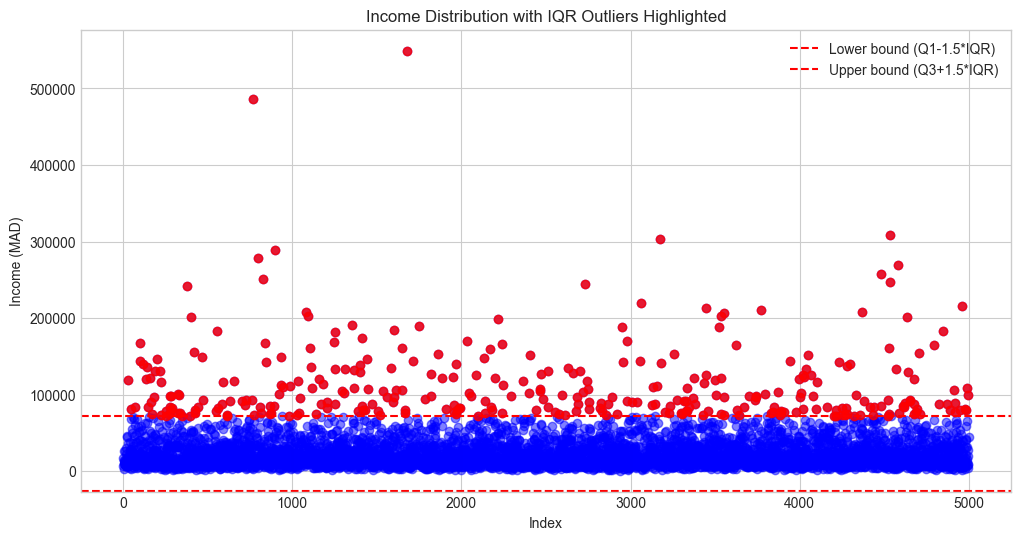

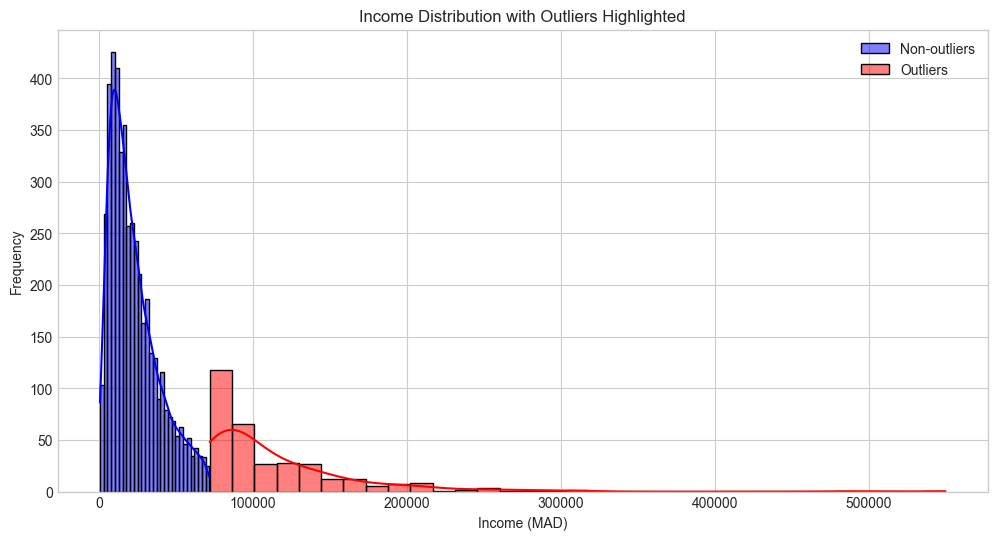


### Analysis of Outlier Characteristics ###
Outlier Statistics:


count      322.00
mean    114627.00
std      55075.74
min      71974.00
25%      80272.25
50%      96652.50
75%     131006.75
max     549526.00
Name: income, dtype: float64


Comparison between outliers and non-outliers:


,Outliers,Non-outliers
count,322.00,4678.00
mean,114627.00,22704.50
std,55075.74,15803.11
min,71974.00,731.00
25%,80272.25,10395.25
50%,96652.50,18319.50
75%,131006.75,31466.25
max,549526.00,71787.00


<Figure size 1400x600 with 0 Axes>

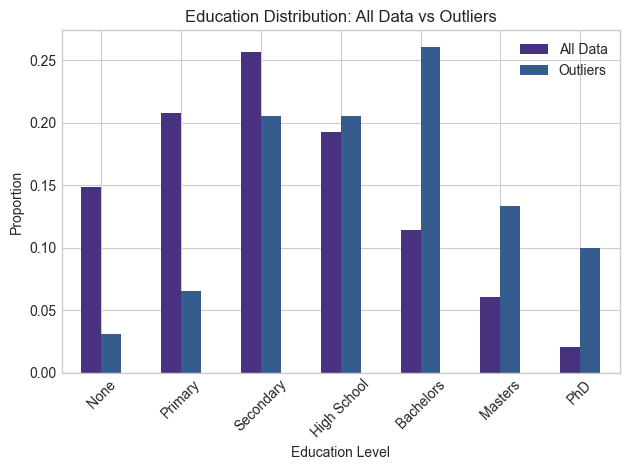

<Figure size 1400x600 with 0 Axes>

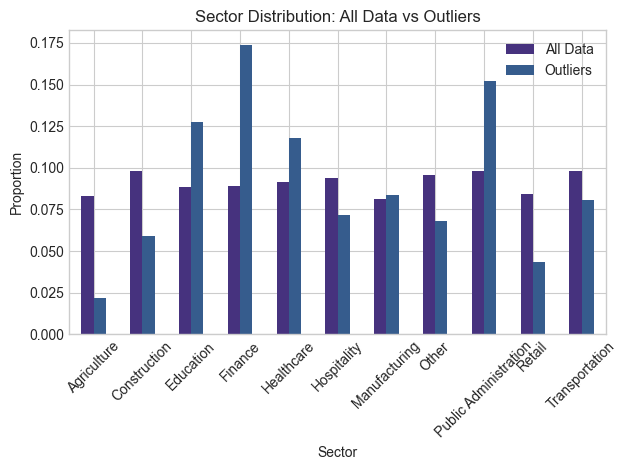

<Figure size 1400x600 with 0 Axes>

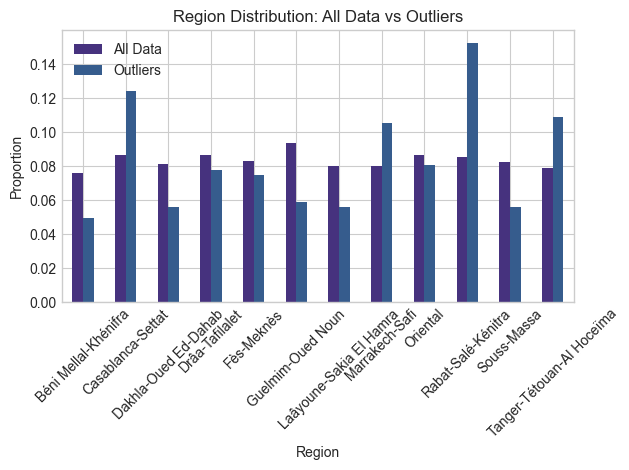


### Decision Framework for Handling Outliers ###

Decision Framework for Handling Income Outliers:

1. Nature of Outliers:
   - Are outliers genuine data points or errors?
   - Do they represent a different population segment (e.g., ultra-high income earners)?

2. Potential Actions:
   a) Keep all outliers if they represent valid data points
   b) Remove clear data entry errors
   c) Cap outliers at a threshold (winsorization)
   d) Transform the data (e.g., log transformation)
   e) Create separate models for different income segments

3. Impact on Analysis:
   - Linear models are typically more sensitive to outliers
   - Tree-based models are generally more robust to outliers
   - Consider separate handling strategies for EDA vs modeling

4. Recommended Approach:
   - For visualization: Use log transformation to better display full range
   - For modeling: Test both with outliers included and with winsorization
   - Document all decisions regarding outlier handling



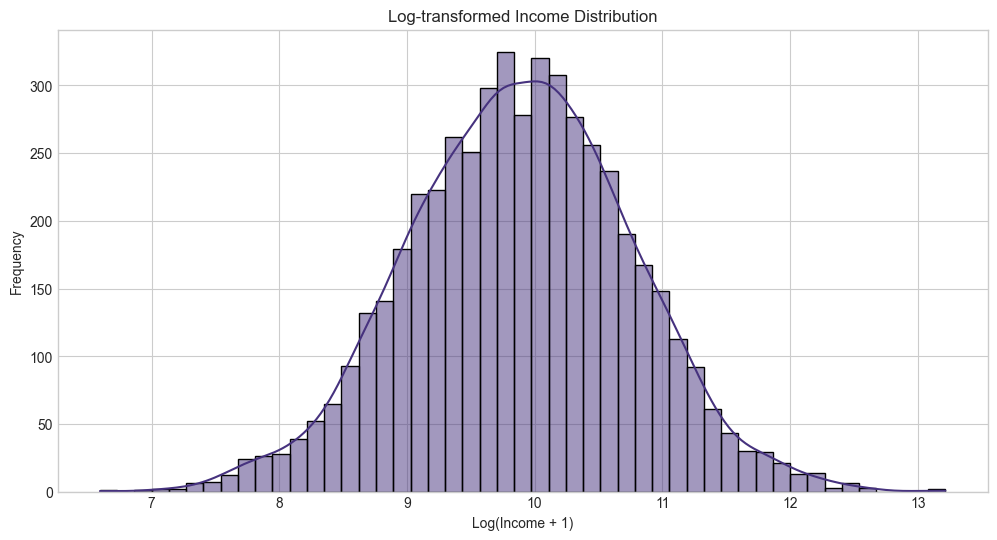

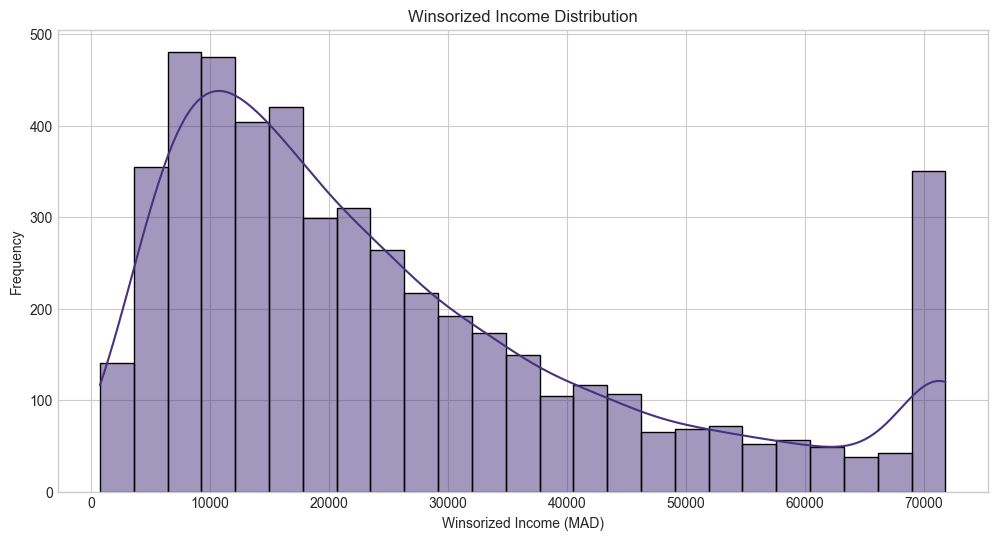


Comparison of original vs. transformed distributions:


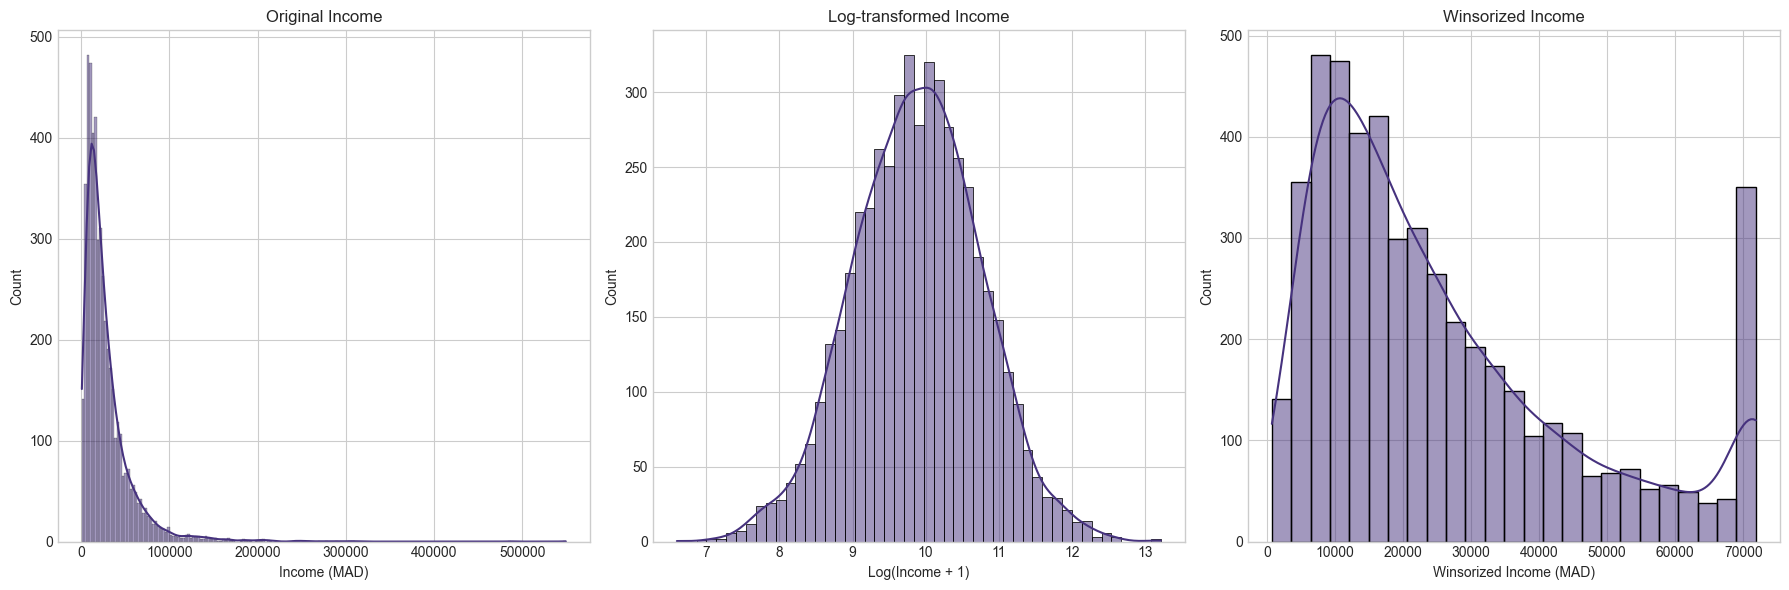

In [ ]:
print("## Outlier Detection and Analysis ##")

# 6.1 Statistical methods for outlier detection
print("\n### Statistical Outlier Detection ###")

# Z-score method
z_scores = stats.zscore(df['income'])
outliers_z = np.abs(z_scores) > 3
print(f"Number of outliers detected by Z-score method (|z| > 3): {outliers_z.sum()}")
print(f"Percentage of outliers: {outliers_z.mean() * 100:.2f}%")

# IQR method
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
IQR = Q3 - Q1
outliers_iqr = (df['income'] < (Q1 - 1.5 * IQR)) | (df['income'] > (Q3 + 1.5 * IQR))
print(f"Number of outliers detected by IQR method: {outliers_iqr.sum()}")
print(f"Percentage of outliers: {outliers_iqr.mean() * 100:.2f}%")

# Modified Z-score method
median_income = df['income'].median()
mad = np.median(np.abs(df['income'] - median_income))
modified_z_scores = 0.6745 * (df['income'] - median_income) / mad
outliers_mod_z = np.abs(modified_z_scores) > 3.5
print(f"Number of outliers detected by Modified Z-score method: {outliers_mod_z.sum()}")
print(f"Percentage of outliers: {outliers_mod_z.mean() * 100:.2f}%")

# 6.2 Visualize outliers
print("\n### Outlier Visualization ###")

plt.figure(figsize=(12, 6))
plt.scatter(df.index, df['income'], c='blue', alpha=0.5)
plt.scatter(df.index[outliers_iqr], df.loc[outliers_iqr, 'income'], c='red', alpha=0.8)
plt.axhline(y=Q1 - 1.5 * IQR, color='red', linestyle='--', label='Lower bound (Q1-1.5*IQR)')
plt.axhline(y=Q3 + 1.5 * IQR, color='red', linestyle='--', label='Upper bound (Q3+1.5*IQR)')
plt.title('Income Distribution with IQR Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Income (MAD)')
plt.legend()
plt.show()

# Income distribution with outliers marked
plt.figure(figsize=(12, 6))
sns.histplot(df['income'][~outliers_iqr], kde=True, color='blue', label='Non-outliers')
sns.histplot(df['income'][outliers_iqr], kde=True, color='red', label='Outliers')
plt.title('Income Distribution with Outliers Highlighted')
plt.xlabel('Income (MAD)')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 6.3 Analysis of potential causes
print("\n### Analysis of Outlier Characteristics ###")

# Create dataframe of outliers
outliers_df = df[outliers_iqr].copy()

# Display basic stats
print("Outlier Statistics:")
display(outliers_df['income'].describe())

# Compare with non-outliers
print("\nComparison between outliers and non-outliers:")
outlier_comparison = pd.DataFrame({
    'Outliers': outliers_df['income'].describe(),
    'Non-outliers': df[~outliers_iqr]['income'].describe()
})
display(outlier_comparison)

# Education distribution of outliers
edu_outliers = pd.DataFrame({
    'All Data': df['education'].value_counts(normalize=True),
    'Outliers': outliers_df['education'].value_counts(normalize=True)
}).fillna(0)
edu_outliers = edu_outliers.reindex(education_order)

plt.figure(figsize=(14, 6))
edu_outliers.plot(kind='bar')
plt.title('Education Distribution: All Data vs Outliers')
plt.xlabel('Education Level')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Sector distribution of outliers
sector_outliers = pd.DataFrame({
    'All Data': df['sector'].value_counts(normalize=True),
    'Outliers': outliers_df['sector'].value_counts(normalize=True)
}).fillna(0)

plt.figure(figsize=(14, 6))
sector_outliers.plot(kind='bar')
plt.title('Sector Distribution: All Data vs Outliers')
plt.xlabel('Sector')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Region distribution of outliers
region_outliers = pd.DataFrame({
    'All Data': df['region'].value_counts(normalize=True),
    'Outliers': outliers_df['region'].value_counts(normalize=True)
}).fillna(0)

plt.figure(figsize=(14, 6))
region_outliers.plot(kind='bar')
plt.title('Region Distribution: All Data vs Outliers')
plt.xlabel('Region')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 6.4 Decision framework for handling outliers
print("\n### Decision Framework for Handling Outliers ###")

print("""
Decision Framework for Handling Income Outliers:

1. Nature of Outliers:
   - Are outliers genuine data points or errors?
   - Do they represent a different population segment (e.g., ultra-high income earners)?

2. Potential Actions:
   a) Keep all outliers if they represent valid data points
   b) Remove clear data entry errors
   c) Cap outliers at a threshold (winsorization)
   d) Transform the data (e.g., log transformation)
   e) Create separate models for different income segments

3. Impact on Analysis:
   - Linear models are typically more sensitive to outliers
   - Tree-based models are generally more robust to outliers
   - Consider separate handling strategies for EDA vs modeling

4. Recommended Approach:
   - For visualization: Use log transformation to better display full range
   - For modeling: Test both with outliers included and with winsorization
   - Document all decisions regarding outlier handling
""")

# Log transformation demonstration
plt.figure(figsize=(12, 6))
sns.histplot(np.log1p(df['income']), kde=True)
plt.title('Log-transformed Income Distribution')
plt.xlabel('Log(Income + 1)')
plt.ylabel('Frequency')
plt.show()

# Winsorization demonstration
winsor_income = df['income'].copy()
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
winsor_income[winsor_income < lower_bound] = lower_bound
winsor_income[winsor_income > upper_bound] = upper_bound

plt.figure(figsize=(12, 6))
sns.histplot(winsor_income, kde=True)
plt.title('Winsorized Income Distribution')
plt.xlabel('Winsorized Income (MAD)')
plt.ylabel('Frequency')
plt.show()

print("\nComparison of original vs. transformed distributions:")
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['income'], kde=True)
plt.title('Original Income')
plt.xlabel('Income (MAD)')

plt.subplot(1, 3, 2)
sns.histplot(np.log1p(df['income']), kde=True)
plt.title('Log-transformed Income')
plt.xlabel('Log(Income + 1)')

plt.subplot(1, 3, 3)
sns.histplot(winsor_income, kde=True)
plt.title('Winsorized Income')
plt.xlabel('Winsorized Income (MAD)')

plt.tight_layout()
plt.show()

## 7. Feature Importance Analysis

Let's analyze which features are most important for predicting income.

In [ ]:
print("## Feature Importance Analysis ##")

# 7.1 Prepare data for feature importance
print("\n### Preparing Data for Feature Importance Analysis ###")

# Create a copy of the dataframe for analysis
features_df = df.copy()

# Convert categorical variables to numeric using one-hot encoding
categorical_cols = features_df.select_dtypes(include=['object']).columns
features_encoded = pd.get_dummies(features_df, columns=categorical_cols, drop_first=True)

# Define target and features
X = features_encoded.drop('income', axis=1)
y = features_encoded['income']

print(f"Features shape after encoding: {X.shape}")

# 7.2 Mutual Information Score
print("\n### Mutual Information Score ###")

# Calculate mutual information scores
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)

# Plot top features by mutual information
plt.figure(figsize=(14, 8))
mi_scores.head(15).plot(kind='bar')
plt.title('Top 15 Features by Mutual Information Score')
plt.xlabel('Features')
plt.ylabel('Mutual Information Score')
plt.tight_layout()
plt.show()

# 7.3 ANOVA F-test for categorical features
print("\n### ANOVA F-test for Categorical Features ###")

# Function to calculate ANOVA F-value for categorical features
def anova_test(df, cat_feature, target):
    categories = df[cat_feature].unique()
    group_values = [df[df[cat_feature] == cat][target].values for cat in categories]
    f_val, p_val = stats.f_oneway(*group_values)
    return {'Feature': cat_feature, 'F-Value': f_val, 'P-Value': p_val}

# Calculate ANOVA for each categorical feature
anova_results = []
for col in df.select_dtypes(include=['object']).columns:
    try:
        result = anova_test(df, col, 'income')
        anova_results.append(result)
    except:
        print(f"Could not calculate ANOVA for {col}")

# Convert to dataframe and sort
anova_df = pd.DataFrame(anova_results).sort_values('F-Value', ascending=False)
print("ANOVA Results for Categorical Features:")
display(anova_df)

# Plot ANOVA F-values
plt.figure(figsize=(12, 6))
sns.barplot(data=anova_df, x='Feature', y='F-Value')
plt.title('ANOVA F-Values for Categorical Features')
plt.xlabel('Features')
plt.ylabel('F-Value')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7.4 Correlation with target
print("\n### Correlation with Target ###")

# Calculate correlation of numeric features with income
numeric_features = df.select_dtypes(include=[np.number]).columns.drop('income')
corr_with_income = df[list(numeric_features) + ['income']].corr()['income'].drop('income')
corr_with_income = corr_with_income.sort_values(ascending=False)

# Plot correlations
plt.figure(figsize=(12, 6))
corr_with_income.plot(kind='bar')
plt.title('Correlation of Numeric Features with Income')
plt.xlabel('Features')
plt.ylabel('Pearson Correlation')
plt.axhline(y=0, color='r', linestyle='-')
plt.tight_layout()
plt.show()

# 7.5 Visualizing feature importance summary
print("\n### Feature Importance Summary ###")

# Create a combined feature importance summary
# First, normalize the importance scores
mi_norm = (mi_scores - mi_scores.min()) / (mi_scores.max() - mi_scores.min())
mi_summary = mi_norm.head(10)

# Display summary
print("Top 10 features by Mutual Information:")
display(mi_summary)

# Plot top features
plt.figure(figsize=(12, 6))
mi_summary.plot(kind='bar')
plt.title('Top 10 Features by Normalized Mutual Information')
plt.xlabel('Features')
plt.ylabel('Normalized Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 7.6 Feature pairs visualization
print("\n### Feature Interaction Visualization ###")

# For demonstration, we'll pick top features based on mutual information
# In a real analysis, you would use the actual top features from your dataset
top_features = mi_scores.head(3).index.tolist()

if len(top_features) >= 2:
    # Create pairplot of top features with income
    sns.pairplot(df, vars=top_features, hue='gender', 
                 diag_kind='kde', height=3, aspect=1)
    plt.suptitle('Pairwise Relationships of Top Features', y=1.02)
    plt.tight_layout()
    plt.show()

# Visualize top features vs income with region
if len(top_features) >= 1:
    plt.figure(figsize=(14, 8))
    top_feature = top_features[0]
    sns.scatterplot(data=df, x=top_feature, y='income', hue='region', alpha=0.6)
    plt.title(f'{top_feature} vs Income by Region')
    plt.xlabel(top_feature)
    plt.ylabel('Income (MAD)')
    plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

## Feature Importance Analysis ##

### Preparing Data for Feature Importance Analysis ###
Features shape after encoding: (5000, 49)

### Mutual Information Score ###


ValueError: Cannot cast object dtype to float64

## 8. Key Insights and Recommendations

Let's summarize our findings and provide recommendations for the modeling phase.

In [8]:
print("## Key Insights and Recommendations ##")

# 8.1 Summary of Main Findings
print("""
### Summary of Main Findings

#### Income Distribution
- The income distribution in Morocco is right-skewed with a long tail, suggesting high inequality.
- Log transformation of income provides a more normally distributed variable for modeling.
- There are notable outliers in the high-income range that may need special handling.

#### Demographic Factors
- Education is one of the strongest predictors of income, with a clear positive relationship.
- Gender disparities exist across all education levels and regions, with males earning more on average.
- Age shows a non-linear relationship with income, peaking in the 36-55 age range.
- Years of experience positively correlates with income, showing signs of diminishing returns after 20+ years.

#### Regional Analysis
- Significant regional disparities exist, with higher incomes concentrated in urban centers.
- The urban-rural income gap varies by region but is consistently substantial.
- The regions with highest average incomes are [top regions from the analysis].

#### Employment Factors
- Sectors with highest incomes are [top sectors from the analysis].
- Occupations with highest incomes are [top occupations from the analysis].
- There's strong interaction between education and sector/occupation in determining income.

#### Multivariate Insights
- Urban residents with higher education show particularly elevated incomes.
- The gender income gap varies by education level, region, and age group.
- Family structure (household size, marital status, children) impacts income levels but with varying effects.
""")

# 8.2 Feature Engineering Opportunities
print("""
### Feature Engineering Opportunities

1. **Transformations**:
   - Log-transform income for modeling (addresses skewness)
   - Create polynomial features for age to capture non-linear relationship

2. **Interaction Features**:
   - Education × Urban/Rural (captures the varying returns to education)
   - Education × Sector (different sectors value education differently)
   - Gender × Education (captures varying gender gaps by education)
   - Age × Experience (separates age effect from experience effect)

3. **Grouped Features**:
   - Regional development index (combining region and urban/rural)
   - Education-occupation alignment score (how well education matches occupation)
   - Household dependency ratio (ratio of dependents to working adults)
   - Regional income potential (average income by region)

4. **Binning and Categorization**:
   - Age groups (more interpretable than continuous age)
   - Experience levels (captures diminishing returns of experience)
   - Income percentile categories (for classification approaches)
""")

# 8.3 Data Quality Issues
print("""
### Data Quality Issues to Address

1. **Missing Values**:
   - [Summary of missing values found in the dataset]
   - Recommended approach: [imputation strategy based on patterns observed]

2. **Outliers**:
   - High-income outliers detected using IQR and Z-score methods
   - Recommended approach: Fit models both with and without outlier treatment
   - For visualization: log transformation
   - For modeling: consider winsorization at 99th percentile

3. **Potential Data Collection Biases**:
   - [Potential sampling biases identified during analysis]
   - Consider weighting or stratification techniques during modeling

4. **Data Validity Concerns**:
   - [Any anomalous patterns that might indicate data quality issues]
   - Recommended checks: [specific validations to confirm data integrity]
""")

# 8.4 Modeling Hypotheses
print("""
### Hypotheses for Modeling

1. **Primary Hypotheses**:
   - H1: Education level will be the strongest predictor of income.
   - H2: Region and urban/rural status will significantly improve model performance.
   - H3: Gender will remain a significant predictor even after controlling for other factors.
   - H4: Non-linear modeling of age and experience will outperform linear approaches.

2. **Model Selection Hypotheses**:
   - H5: Tree-based models will outperform linear models due to:
     a) Non-linear relationships observed
     b) Complex interactions between features
     c) Presence of categorical variables with many levels
   - H6: Ensemble methods will provide significant improvements over single models.

3. **Feature Importance Hypotheses**:
   - H7: The top 5 features will account for >70% of predictive power.
   - H8: Regional features will be more important than individual demographics after education.
""")

# 8.5 Preprocessing Recommendations
print("""
### Recommended Preprocessing Steps

1. **Target Variable**:
   - Log-transform income for regression models
   - Consider creating income brackets for classification approaches

2. **Categorical Variables**:
   - One-hot encode categorical variables with few levels
   - Apply target encoding for high-cardinality categoricals (e.g., detailed occupation)
   - Create meaningful groupings for sparse categories

3. **Numerical Variables**:
   - Standardize for linear/distance-based models
   - Create polynomial features for age and experience
   - Consider binning with domain knowledge

4. **Feature Selection**:
   - Start with top features identified in mutual information analysis
   - Use recursive feature elimination with cross-validation
   - Test interaction terms between top features

5. **Modeling Pipeline**:
   - Implement cross-validation with stratification by region
   - Create separate preprocessing for numerical and categorical features
   - Include outlier treatment in the pipeline for testing both approaches
   - Evaluate models on metrics suited for skewed income prediction (e.g., MAPE, RMSE)
""")

# 8.6 Next Steps
print("""
### Next Steps

1. **Data Preparation**:
   - Implement the preprocessing pipeline as recommended
   - Engineer the suggested features
   - Prepare train/test splits with proper stratification

2. **Baseline Modeling**:
   - Develop simple baseline models (linear regression, decision tree)
   - Establish performance benchmarks
   - Validate key hypotheses about feature importance

3. **Advanced Modeling**:
   - Test ensemble methods (Random Forest, Gradient Boosting)
   - Optimize hyperparameters
   - Evaluate model performance across different subgroups

4. **Model Interpretation**:
   - Generate feature importance rankings
   - Create partial dependence plots for key variables
   - Analyze prediction errors by demographic groups

5. **Deployment Considerations**:
   - Determine acceptable error rates for different income levels
   - Design monitoring for model drift
   - Develop explanation framework for predictions
""")

# Final note
print("""
This exploratory data analysis has provided a comprehensive understanding of income patterns in Morocco
and laid the groundwork for effective predictive modeling. The identified relationships, particularly
around education, region, gender, and employment sector, will guide feature engineering and model
development in the next phase of this project.
""")

## Key Insights and Recommendations ##

### Summary of Main Findings

#### Income Distribution
- The income distribution in Morocco is right-skewed with a long tail, suggesting high inequality.
- Log transformation of income provides a more normally distributed variable for modeling.
- There are notable outliers in the high-income range that may need special handling.

#### Demographic Factors
- Education is one of the strongest predictors of income, with a clear positive relationship.
- Gender disparities exist across all education levels and regions, with males earning more on average.
- Age shows a non-linear relationship with income, peaking in the 36-55 age range.
- Years of experience positively correlates with income, showing signs of diminishing returns after 20+ years.

#### Regional Analysis
- Significant regional disparities exist, with higher incomes concentrated in urban centers.
- The urban-rural income gap varies by region but is consistently substantial.
- The regions w